In [1]:
import os
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm

from astropy import units as u 
from astropy.table import Table

from snewpy.neutrino import Flavor, MassHierarchy, MixingParameters
from snewpy.models import Nakazato_2013
from snewpy.models.ccsn import Fornax_2022
from snewpy.models.ccsn import Bollig_2016
from snewpy.models.ccsn import Sukhbold_2015
from snewpy.models.ccsn import Zha_2021
from snewpy.models.ccsn import Tamborra_2014
from snewpy.flavor_transformation import AdiabaticMSW, NonAdiabaticMSWH, \
                                         TwoFlavorDecoherence, ThreeFlavorDecoherence, \
                                         NeutrinoDecay, AdiabaticMSWes, NonAdiabaticMSWes
from asteria import set_rcparams
from asteria.simulation import Simulation

%matplotlib inline

C:\Users\sanya\AppData\Local\Temp\ipykernel_13280\3933108848.py:13: FutureWarning: snewpy.models.Nakazato_2013 is moved to snewpy.models.ccsn.Nakazato_2013
  from snewpy.models import Nakazato_2013


In [2]:
import numpy as np
from scipy.special import logsumexp, betaln, gammaln
from scipy.stats import norm
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd


def pt_d_sample_test(data1, data2, c=1, max_depth=-1, qdist=norm.ppf, aj=lambda depth: depth**2, log_BF=False):
    old_expressions = np.get_printoptions()['threshold']
    np.set_printoptions(threshold=max(max_depth, old_expressions))

    if max_depth < 0:
        max_depth = max(1, int(np.floor(np.log2(len(data1)) / 2)))

    # Combine datasets and create a group identifier
    binary = np.concatenate((np.zeros(len(data1)), np.ones(len(data2))))
    continuous = np.concatenate((data1, data2))
    data = np.column_stack([scale(continuous), binary])
    X = data[:, 0]  # assign the scaled value to X

    p_H0 = pt_marginal_likelihood(X, low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj)

    discrete_values = np.unique(binary)

    p_H1 = max([pt_marginal_likelihood(data[data[:, 1] == i, 0], low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj) +
                pt_marginal_likelihood(data[data[:, 1] != i, 0], low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj)
                for i in discrete_values])

    n_hypotheses = len(discrete_values)
    logbf = p_H0 - p_H1 + np.log(n_hypotheses)
    np.set_printoptions(threshold=old_expressions)

    if log_BF:
        return logbf
    else:
        bf = np.exp(logbf)
        return bf


def pt_marginal_likelihood(data, low, up, c, depth, max_depth, qdist, aj):
    if depth == max_depth:
        return 0

    if isinstance(low, (int, float)):  # if low is an integer
        n_j = [
            np.sum((qdist(low) < data) & (data <= qdist((low + up) / 2))),
            np.sum((qdist((low + up) / 2) < data) & (data <= qdist(up)))
        ]  # counts the number of data in each interval (2 vector).
    else:
        n_j = [
            np.sum((qdist(low[0]) < data[:, 0]) & (data[:, 0] <= qdist((low[0] + up[0]) / 2)) &
                   (qdist(low[1]) < data[:, 1]) & (data[:, 1] <= qdist((low[1] + up[1]) / 2))),
            np.sum((qdist((low[0] + up[0]) / 2) < data[:, 0]) & (data[:, 0] <= qdist(up[0])) &
                   (qdist(low[1]) < data[:, 1]) & (data[:, 1] <= qdist((low[1] + up[1]) / 2))),
            np.sum((qdist(low[0]) < data[:, 0]) & (data[:, 0] <= qdist((low[0] + up[0]) / 2)) &
                   (qdist((low[1] + up[1]) / 2) < data[:, 1]) & (data[:, 1] <= qdist(up[1]))),
            np.sum((qdist((low[0] + up[0]) / 2) < data[:, 0]) & (data[:, 0] <= qdist(up[0])) &
                   (qdist((low[1] + up[1]) / 2) < data[:, 1]) & (data[:, 1] <= qdist(up[1])))
        ]  # 4 vector 

    if np.sum(n_j) == 0:
        return 0

    a_j = c * aj(depth)

    if len(n_j) == 2:
        logl = betaln(n_j[0] + a_j, n_j[1] + a_j) - betaln(a_j, a_j)  # log of beta function
    else:
        logl = lmbeta(n_j[0] + a_j, n_j[1] + a_j, n_j[2] + a_j, n_j[3] + a_j) - lmbeta(a_j, a_j, a_j, a_j)

    if isinstance(low, (int, float)):
        likelihoods = [
            pt_marginal_likelihood(data, low, (low + up) / 2, c, depth + 1, max_depth, qdist, aj),
            pt_marginal_likelihood(data, (low + up) / 2, up, c, depth + 1, max_depth, qdist, aj)
        ]  # likelihood of subpartitions
    else:
        likelihoods = [
            pt_marginal_likelihood(data, low, (low + up) / 2, c, depth + 1, max_depth, qdist, aj),
            pt_marginal_likelihood(data, (low + up) / 2, up, c, depth + 1, max_depth, qdist, aj),
            pt_marginal_likelihood(data, [low[0], (low[1] + up[1]) / 2], [(low[0] + up[0]) / 2, up[1]],
                                   c, depth + 1, max_depth, qdist, aj),
            pt_marginal_likelihood(data, [(low[0] + up[0]) / 2, low[1]], [up[0], (low[1] + up[1]) / 2],
                                   c, depth + 1, max_depth, qdist, aj)
        ]

    return logl + np.sum(likelihoods)


def lmbeta(*args):
    return np.sum(gammaln(args)) - gammaln(np.sum(args))


def is_discrete(X):
    return np.all(np.isin(X, np.arange(11)))  # evaluates to TRUE only if every element of X lies within the specified range of 0 to 10.


def scale(data):
    return (data - np.mean(data)) / np.std(data)


**MODEL DEPENDENT**

In [3]:
sukh_param=list(params for params in Sukhbold_2015.get_param_combinations() if params['progenitor_mass'].value == 27 
                      and params['eos']=='LS220')

In [8]:
help(Simulation)

Help on class Simulation in module asteria.simulation:

class Simulation(builtins.object)
 |  Simulation(config=None, *, model=None, distance=<Quantity 10. kpc>, res_dt=<Quantity 2. ms>, flavors=None, hierarchy=None, interactions=<enum 'Interactions'>, mixing_scheme=None, mixing_angle=None, E=None, Emin=None, Emax=None, dE=None, t=None, tmin=None, tmax=None, dt=None, geomfile=None, effvolfile=None)
 |  
 |  Top-level class for performing ASTERIA's core simulation routine, and handler for the resulting outputs
 |  
 |  Methods defined here:
 |  
 |  __init__(self, config=None, *, model=None, distance=<Quantity 10. kpc>, res_dt=<Quantity 2. ms>, flavors=None, hierarchy=None, interactions=<enum 'Interactions'>, mixing_scheme=None, mixing_angle=None, E=None, Emin=None, Emax=None, dE=None, t=None, tmin=None, tmax=None, dt=None, geomfile=None, effvolfile=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  avg_dom_signal(self, dt=None, flavor=None)
 |      Re

In [4]:
forn_param=list(params for params in Fornax_2022.get_param_combinations() if params['progenitor_mass'].value == 12.54 
                      )

In [5]:
forn_param

[{'progenitor_mass': <Quantity 12.54 solMass>}]

In [6]:
model_a = {'name': 'Sukhbold_2015',
            'param': sukh_param[0]
              }

In [7]:
labels=['nmo','imo']
norms=[]
nmos=[]
imos=[]
sims1=[nmos,imos]
for i in range(654,1001):
    sim_i = Simulation(model=model_a,
                     distance=10 * u.kpc, 
                     Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                     tmin=-10*u.s,  tmax=10*u.s,    dt=1*u.ms,
                     mixing_scheme='AdiabaticMSW',
                     hierarchy='inverted')


    sim_n = Simulation(model=model_a,
                     distance=10 * u.kpc, 
                     Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                     tmin=-10*u.s,tmax=10*u.s, dt=1*u.ms,
                     mixing_scheme='AdiabaticMSW',
                     hierarchy='normal')
    sim_i.run()
    sim_n.run()
    for j,simm in enumerate([sim_n,sim_i]): 
        with open("Sukhbold_eos={}_M={}_mix={}_num={}.pkl".format(sukh_param[0]['eos'],
                                                                  sukh_param[0]['progenitor_mass'].value, 
                                                                 labels[j], i), 'wb') as f:
            pickle.dump(simm, f)
        sims1[j].append(simm)

C:\Users\sanya\miniconda3\lib\site-packages\snewpy\models\base.py:302: RuntimeWarning: divide by zero encountered in log
  np.exp(np.log(L) - (2+a)*np.log(Ea) + (1+a)*np.log(1+a)
C:\Users\sanya\miniconda3\lib\site-packages\snewpy\models\base.py:302: RuntimeWarning: invalid value encountered in subtract
  np.exp(np.log(L) - (2+a)*np.log(Ea) + (1+a)*np.log(1+a)
C:\Users\sanya\miniconda3\lib\site-packages\snewpy\models\base.py:303: RuntimeWarning: divide by zero encountered in divide
  - loggamma(1+a) + a*np.log(E) - (1+a)*(E/Ea)) / (u.erg * u.s)


In [11]:
labels=['nmo','imo']
nmos=[]
imos=[]
sims1=[nmos,imos]

for i in range(100):
    for j,lab in enumerate(labels): 
        with open("Sukhbold_eos={}_M={}_mix={}_num={}.pkl".format(sukh_param[0]['eos'], 
                                                                 sukh_param[0]['progenitor_mass'].value,
                                                                 labels[j], i), 'rb') as f:
            mod=pickle.load(f)
        sims1[j].append(mod)

In [95]:
np.where(t==-5*u.s)[0][0]

2500

Text(0.5, 1.0, 'Detector Signal for 100 Simulations, Sukhbold with M=27 and EOS=LS220, d=10kpc')

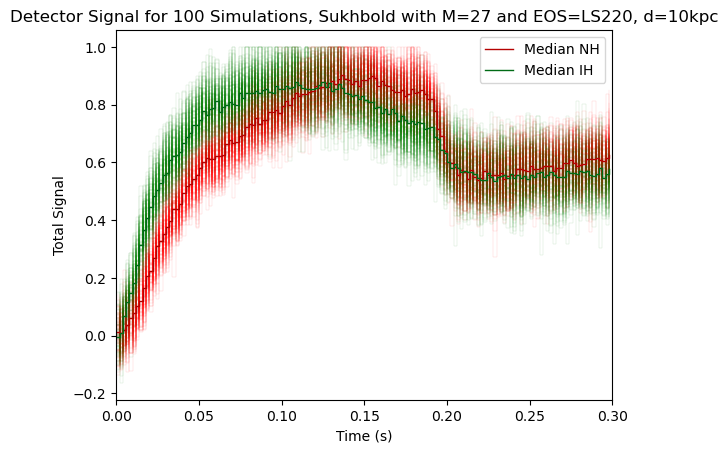

In [16]:
dt = 2 * u.ms
colors=['blue','red','green','orange']
labels=['Normal','NH','IH']

hits_nh=[]
hits_ih=[]
hits_tot=[hits_nh,hits_ih]

for i in range(100):
    for j in range(0,2):
        simm=sims1[j][i]
        simm.rebin_result(dt)
        simm.scale_result(10*u.kpc)
        t, hits = simm.detector_signal(dt)
        bg = simm.detector.i3_bg(dt, size=hits.size) + simm.detector.dc_bg(dt, size=hits.size)
        sig=bg+hits
        id1=np.where(t==-5*u.s)[0][0]
        id2=np.where(t==-.5*u.s)[0][0]
        id3=np.where(t==5*u.s)[0][0]
        id4=np.where(t==10*u.s)[0][0]
        id5=np.where(t==0*u.s)[0][0]
        id6=np.where(t==.3*u.s)[0][0]
        mean_under=np.mean(np.append(sig[id1:id2],sig[id3:id4]))
        data=np.subtract(sig,mean_under)[id5:id6]
        
        
        m=np.max(data)
        norm_data=data/m
        
        hits_tot[j].append(norm_data)
        
        plt.step(t[id5:id6], norm_data, where='post',lw=.2,color=colors[j+1],alpha=.3)

med_nh=np.median(hits_tot[0],axis=0)
med_ih=np.median(hits_tot[1],axis=0)
plt.step(t[id5:id6],med_nh,where='post',lw=1,color='#b50202',label='Median NH')
plt.step(t[id5:id6],med_ih,where='post',lw=1,color='#016b16',label='Median IH')

plt.legend()
plt.xlim(0,.3)
plt.xlabel('Time (s)')
plt.ylabel('Total Signal')
plt.title('Detector Signal for 100 Simulations, Sukhbold with M=27 and EOS=LS220, d=10kpc')

**BAYES FACTOR**

In [87]:
t[5500]

<Quantity 1. s>

In [23]:
bfs_norm=[]
dt = 2*u.ms

for i in range(100):
    for j in range(100):
        simm_nh=sims1[0][i]
        simm_nh.rebin_result(dt)
        simm.scale_result(20*u.kpc)
        
        data1=hits_tot[0][i]
        
        m=np.max(data1)
        norm_data1=data1/m
        
        
        data2=hits_tot[1][i]
        m=np.max(data2)
        norm_data2=data2/m
        
        log_bf = pt_d_sample_test(data1, data2, log_BF=True)
        bfs_norm.append(log_bf)
        

Text(0.5, 1.0, 'Bayes Factors for 10000 Combinations of Normalized NH and IH for d=10kpc')

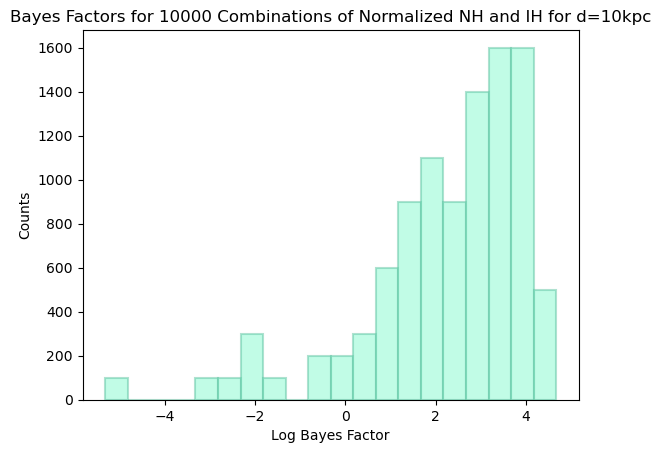

In [24]:
plt.hist(bfs_norm, alpha=0.5, color='#84facf', edgecolor='#60c4a3', linewidth=1.5,bins=20)
plt.xlabel('Log Bayes Factor')
plt.ylabel('Counts')
plt.title('Bayes Factors for 10000 Combinations of Normalized NH and IH for d=10kpc')

**KS TEST**

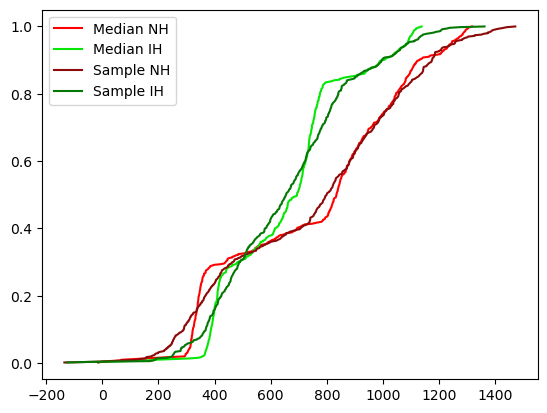

In [6]:
dt = 2 * u.ms
colors=['blue','red','green','orange']
labels=['Normal','NH','IH']

hits_nh=[]
hits_ih=[]
hits_tot=[hits_nh,hits_ih]

for i in range(100):
    for j in range(0,2):
        simm=sims1[j][i]
        simm.rebin_result(dt)
        t, hits = simm.detector_signal(dt)
        bg = simm.detector.i3_bg(dt, size=hits.size) + simm.detector.dc_bg(dt, size=hits.size)
        sig=hits+bg
        id1=np.where(t==-5*u.s)[0][0]
        id2=np.where(t==-.5*u.s)[0][0]
        id3=np.where(t==5*u.s)[0][0]
        id4=np.where(t==10*u.s)[0][0]
        id5=np.where(t==0*u.s)[0][0]
        id6=np.where(t==1*u.s)[0][0]
        mean_under=np.mean(np.append(sig[id1:id2],sig[id3:id4]))
        data=np.subtract(sig,mean_under)[id5:id6]
        hits_tot[j].append(data)
        
med_nh=np.median(hits_tot[0],axis=0)
med_ih=np.median(hits_tot[1],axis=0)

cdf_med_nh=np.sort(med_nh)
cdf_med_ih=np.sort(med_ih)

plt.plot(cdf_med_nh, np.arange(1, len(cdf_med_nh) + 1) / len(cdf_med_nh), color='red',label='Median NH')
plt.plot(cdf_med_ih, np.arange(1, len(cdf_med_ih) + 1) / len(cdf_med_ih), color='#05e605',label='Median IH')

plt.plot(np.sort(hits_tot[0][0]), np.arange(1, len(hits_tot[0][0]) + 1) / len(hits_tot[0][0]), 
         color='#8c0a0a',label='Sample NH')
plt.plot(np.sort(hits_tot[1][0]), np.arange(1, len(hits_tot[1][0]) + 1) / len(hits_tot[1][0]), 
         color='#047804',label='Sample IH')

plt.legend()


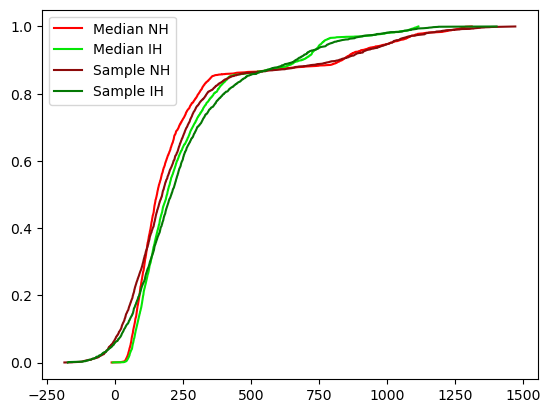

In [7]:
dt = 2 * u.ms
colors=['blue','red','green','orange']
labels=['Normal','NH','IH']

hits_nh=[]
hits_ih=[]
hits_tot=[hits_nh,hits_ih]

for i in range(100):
    for j in range(0,2):
        simm=sims1[j][i]
        simm.rebin_result(dt)
        t, hits = simm.detector_signal(dt)
        bg = simm.detector.i3_bg(dt, size=hits.size) + simm.detector.dc_bg(dt, size=hits.size)
        sig=hits+bg
        id1=np.where(t==-5*u.s)[0][0]
        id2=np.where(t==-.5*u.s)[0][0]
        id3=np.where(t==5*u.s)[0][0]
        id4=np.where(t==10*u.s)[0][0]
        id5=np.where(t==0*u.s)[0][0]
        id6=np.where(t==5*u.s)[0][0]
        mean_under=np.mean(np.append(sig[id1:id2],sig[id3:id4]))
        data=np.subtract(sig,mean_under)[id5:id6]
        hits_tot[j].append(data)
        
med_nh=np.median(hits_tot[0],axis=0)
med_ih=np.median(hits_tot[1],axis=0)

cdf_med_nh=np.sort(med_nh)
cdf_med_ih=np.sort(med_ih)

plt.plot(cdf_med_nh, np.arange(1, len(cdf_med_nh) + 1) / len(cdf_med_nh), color='red',label='Median NH')
plt.plot(cdf_med_ih, np.arange(1, len(cdf_med_ih) + 1) / len(cdf_med_ih), color='#05e605',label='Median IH')

plt.plot(np.sort(hits_tot[0][0]), np.arange(1, len(hits_tot[0][0]) + 1) / len(hits_tot[0][0]), 
         color='#8c0a0a',label='Sample NH')
plt.plot(np.sort(hits_tot[1][0]), np.arange(1, len(hits_tot[1][0]) + 1) / len(hits_tot[1][0]), 
         color='#047804',label='Sample IH')

plt.legend()


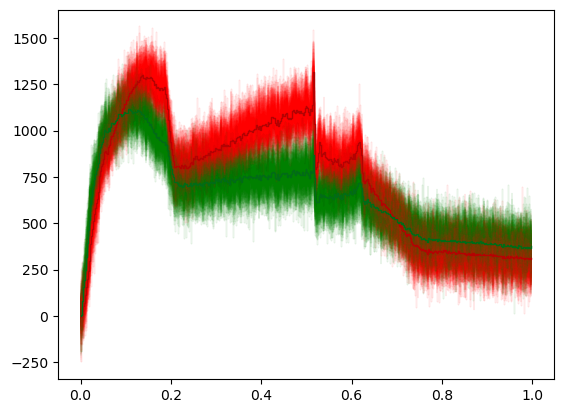

In [19]:
for i in range(100,200):
    for j in range(0,2):
        dat=hits_tot[j][i]
        plt.step(t[id5:id6], dat, where='post',lw=.2,color=colors[j+1],alpha=.3)

plt.step(t[id5:id6],med_nh,where='post',lw=1,color='#b50202',label='Median NH')
plt.step(t[id5:id6],med_ih,where='post',lw=1,color='#016b16',label='Median IH')

In [69]:
ks_nh=[]
cdfs_nh=[]
pval_nh=[]

for i in range(100):
    sorted_sig=np.sort(hits_tot[0][i])
    cdfs_nh.append(sorted_sig)
    statistic, p_value = stats.ks_2samp(sorted_sig, cdfs_nh[0], alternative='two-sided', mode='auto')
    pval_nh.append(p_value)
    ks_nh.append(statistic)

In [70]:
ks_ih=[]
cdfs_ih=[]
pval_ih=[]

for i in range(100):
    sorted_sig=np.sort(hits_tot[1][i])
    cdfs_ih.append(sorted_sig)
    statistic, p_value = stats.ks_2samp(sorted_sig, cdfs_nh[0], alternative='two-sided', mode='auto')
    pval_ih.append(p_value)
    ks_ih.append(statistic)

In [28]:
ks_nh_med=[]
cdfs_nh_med=[]
pval_nh_med=[]

for i in range(1001):
    sorted_sig=np.sort(hits_tot[0][i])
    cdfs_nh_med.append(sorted_sig)
    statistic, p_value = stats.ks_2samp(sorted_sig, cdf_med_nh, alternative='two-sided', mode='auto')
    pval_nh_med.append(p_value)
    ks_nh_med.append(statistic)

In [29]:
ks_ih_med=[]
cdfs_ih_med=[]
pval_ih_med=[]

for i in range(1001):
    sorted_sig=np.sort(hits_tot[1][i])
    cdfs_ih_med.append(sorted_sig)
    statistic, p_value = stats.ks_2samp(sorted_sig, cdf_med_nh, alternative='two-sided', mode='auto')
    pval_ih_med.append(p_value)
    ks_ih_med.append(statistic)

In [80]:
ks_ih_medih=[]
cdfs_ih_medih=[]
pval_ih_medih=[]

for i in range(100):
    sorted_sig=np.sort(hits_tot[1][i])
    cdfs_ih_medih.append(sorted_sig)
    statistic, p_value = stats.ks_2samp(sorted_sig, cdf_med_ih, alternative='two-sided', mode='auto')
    pval_ih_medih.append(p_value)
    ks_ih_medih.append(statistic)

Text(0.5, 1.0, 'KS Distances for NH and IH, from t=0 to t=1')

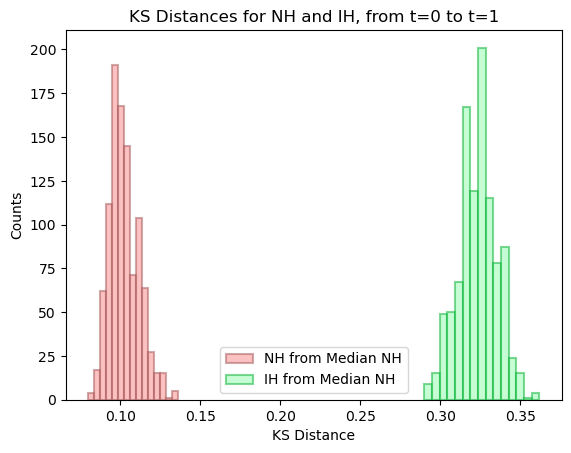

In [30]:
plt.hist(ks_nh_med, alpha=0.5, color='#fa8787', edgecolor='#a35656', linewidth=1.5,label='NH from Median NH',bins=15)
plt.hist(ks_ih_med, alpha=0.5, color='#90fcad', edgecolor='#02b031', linewidth=1.5,label='IH from Median NH',bins=15)
#plt.hist(ks_ih_medih, alpha=0.5, color='#51fafc', edgecolor='#3fc3c4', linewidth=1.5,label='IH from Median IH',bins=15)

plt.legend()
#plt.xlim(0,.2)
plt.xlabel('KS Distance')
plt.ylabel('Counts')
plt.title('KS Distances for NH and IH, from t=0 to t=1')

In [133]:
def compute_ks_pval(area_tot,ks_dist,statistic):
    dist_above=ks_dist[ks_dist>=statistic]
    if len(dist_above)==0:
        return 1/area_tot
    else:
        return len(dist_above)/area_tot

In [141]:
np.sort(ks_ih_med)[1]

0.13346153846153846

In [150]:
np.sort(ks_nh_med)[-1]

0.13423076923076924

In [151]:
ks_nh_med=np.array(ks_nh_med)
ks_nh_med[ks_nh_med>=np.sort(ks_ih_med)[1]]

array([0.13346154, 0.13423077, 0.13346154])

(array([98.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([0.01 , 0.012, 0.014, 0.016, 0.018, 0.02 , 0.022, 0.024, 0.026,
        0.028, 0.03 ]),
 <BarContainer object of 10 artists>)

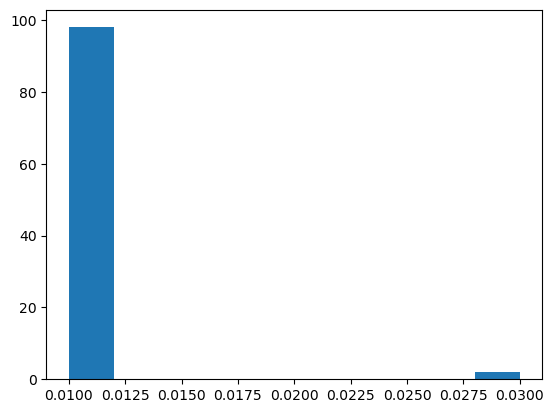

In [139]:
p_vals=[]
for i,stat in enumerate(ks_ih_med):
    p_vals.append(compute_ks_pval(100,np.array(ks_nh_med),stat))
    
plt.hist(p_vals,bins=10,range=(.01,.03), alpha=0.5, color='#90fcad', edgecolor='#02b031', linewidth=1.5,)
plt.title('P values for KS tests of IH vs Median NH')
plt.xlabel('p value')
plt.ylabel('counts')

Text(0.5, 1.0, 'KS Distances for NH and IH Compared to Random NH')

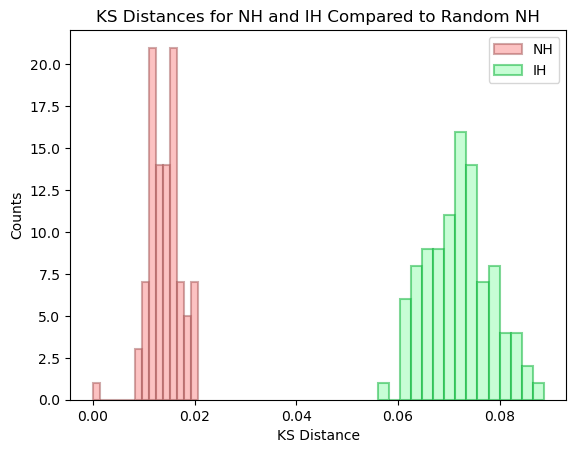

In [75]:
plt.hist(ks_nh, alpha=0.5, color='#fa8787', edgecolor='#a35656', linewidth=1.5,label='NH',bins=15)
plt.hist(ks_ih, alpha=0.5, color='#90fcad', edgecolor='#02b031', linewidth=1.5,label='IH',bins=15)
plt.legend()
plt.xlabel('KS Distance')
plt.ylabel('Counts')
plt.title('KS Distances for NH and IH Compared to Random NH')

**MODEL INDEPENDENT, MASS DEPENDENT**

In [2]:
sukh_param_sfho=list(params for params in Sukhbold_2015.get_param_combinations() if params['progenitor_mass'].value == 27 
                      and params['eos']=='SFHo')
sukh_param_ls220=list(params for params in Sukhbold_2015.get_param_combinations() if params['progenitor_mass'].value == 27 
                      and params['eos']=='LS220')


forn_param=list(params for params in Fornax_2022.get_param_combinations() if params['progenitor_mass'].value == 26.99)

zha_param=list(params for params in Zha_2021.get_param_combinations() if params['progenitor_mass'].value == 26)

tamb_param=list(params for params in Tamborra_2014.get_param_combinations() if params['progenitor_mass'].value == 27
               and params['direction']==1)


In [3]:
sukh_model_sfho = {'name': 'Sukhbold_2015',
            'param': sukh_param_sfho[0]
              }

sukh_model_ls220 = {'name': 'Sukhbold_2015',
            'param': sukh_param_ls220[0]
              }

forn_model = {'name': 'Fornax_2022',
            'param': forn_param[0]
              }

zha_model = {'name': 'Zha_2021',
            'param': zha_param[0]
              }

tamb_model = {'name': 'Tamborra_2014',
            'param': tamb_param[0]
              }

In [5]:
zha_model

{'name': 'Zha_2021',
 'param': {'progenitor_mass': <Quantity 26. solMass>, 'eos': 'STOS_B145'}}

In [35]:
models=[sukh_model_sfho,sukh_model_ls220,forn_model,zha_model,tamb_model]
labels=['nmo','imo']
hie=['normal','inverted']
mod_names=['sukh_sfho','sukh_ls220','forn','zha','tamb']

sims = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

for i,mod in enumerate(models):
    for j,lab in enumerate(labels):
        pred = Simulation(model=mod,
                                         distance=10 * u.kpc, 
                                         Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                                         tmin=-10*u.s,  tmax=10*u.s,    dt=1*u.ms,
                                         mixing_scheme='AdiabaticMSW',
                                         hierarchy=hie[j])
        pred.run()
        if mod['name']=='Fornax_2022':
            with open("{}_M={}_mix={}.pkl".format(mod['name'], mod['param']['progenitor_mass'].value,
                                                    lab), 'wb') as f:
                pickle.dump(pred, f)
        else:
            with open("{}_M={}_eos={}_mix={}.pkl".format(mod['name'], mod['param']['progenitor_mass'].value,
                                                        mod['param']['eos'],
                                                        lab), 'wb') as f:
                pickle.dump(pred, f)
        sims[mod_names[i]].append(pred)

Expect a reduction in performance and increase in simulation run times.
Expect a reduction in performance and increase in simulation run times.
C:\Users\sanya\miniconda3\lib\site-packages\snewpy\models\__init__.py:53: UserWarning: Argument `eos` is deprecated.
  return getattr(module, model_name)(**user_param)


s26.dat:   0%|          | 0.00/307k [00:00<?, ?iB/s]

s27.0c_3D_dir1_LS220_nue:   0%|          | 0.00/11.9k [00:00<?, ?iB/s]

s27.0c_3D_dir1_LS220_nux:   0%|          | 0.00/11.2k [00:00<?, ?iB/s]

s27.0c_3D_dir1_LS220_nuebar:   0%|          | 0.00/11.9k [00:00<?, ?iB/s]

In [4]:
models=[sukh_model_sfho,sukh_model_ls220,forn_model,zha_model,tamb_model]
labels=['nmo','imo']
hie=['normal','inverted']
mod_names=['sukh_sfho','sukh_ls220','forn','zha','tamb']

sims = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

for i,mod in enumerate(models):
    for j,lab in enumerate(labels):
        if mod['name']=='Fornax_2022':
            with open("{}_M={}_mix={}.pkl".format(mod['name'], mod['param']['progenitor_mass'].value,
                                                    lab), 'rb') as f:
                sims[mod_names[i]].append(pickle.load(f))
        else:
            with open("{}_M={}_eos={}_mix={}.pkl".format(mod['name'], mod['param']['progenitor_mass'].value,
                                                        mod['param']['eos'],
                                                        lab), 'rb') as f:
                sims[mod_names[i]].append(pickle.load(f))

**CHI SQ TEST**

In [13]:
hits_tot = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

hits_norm = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

hits_shift = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

dt=10*u.ms
#max_t_dat = t1[np.argmax(norm_data_hits[0])]
for i,mod in enumerate(mod_names):
    for j in range(2):
        simm=sims[mod][j]
        simm.rebin_result(dt)
        simm.scale_result(10*u.kpc)
        t, hits = simm.detector_signal(dt)
        id5=np.where(t==.02*u.s)[0][0]
        id6=np.where(t==.46*u.s)[0][0]
        
        data=hits[id5:id6]
        hits_tot[mod].append(data) 
        
        s=np.sum(data)
        m=np.max(data)
        ta=data[np.where(t[id5:id6]==.4*u.s)[0][0]]
        norm_hits_sum=data/s
        
        hits_norm[mod].append(norm_hits_sum) 


In [14]:
dt=10*u.ms
data_sim=sims['sukh_sfho'][0]
data_sim.rebin_result(dt)
data_sim.scale_result(10*u.kpc)
norm_data_hits=[]
for i in range(1000):
    t, hits = data_sim.detector_signal(dt)
    bg1 = data_sim.detector.i3_bg(dt,size=hits.size) + data_sim.detector.dc_bg(dt,size=hits.size)
    sig=bg1+hits
    id1=np.where(t==-5*u.s)[0][0]
    id2=np.where(t==-.5*u.s)[0][0]
    id5=np.where(t==.02*u.s)[0][0]
    id6=np.where(t==.46*u.s)[0][0]

    mean_under=np.mean(sig[id1:id2])
    data_hits=np.subtract(sig,mean_under)[id5:id6]

    s=np.sum(data_hits)
    m=np.max(data_hits)
    ta=data_hits[np.where(t[id5:id6]==.4*u.s)[0][0]]
    norm_data_hits.append(data_hits/s)

Text(0.5, 1.0, 'Normal Hierarchy for Models with M=27')

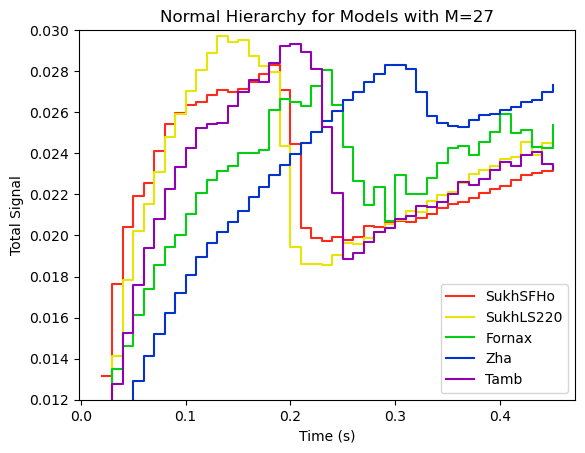

In [71]:
#dt = 10 * u.ms
colors_nmo=['#fc2b1c','#e6e602','#02cf13','#0232cf','#9200b3']
colors_imo=['#fc968b','#faf1b1','#7ffc72','#91aafa','#e88bfc']
mod_names=['sukh_sfho','sukh_ls220','forn','zha','tamb']
mod_labs=['SukhSFHo','SukhLS220','Fornax','Zha','Tamb']


for i,mod in enumerate(mod_names):
    plt.step(t[id5:id6], hits_norm[mod][0], where='post',color=colors_nmo[i],label=f'{mod_labs[i]}')

#plt.step(t[id5:id6], norm_data_hits[0], where='post',color='orange')
    
plt.legend(loc='lower right')
plt.ylim(.012,.03)
plt.xlabel('Time (s)')
plt.ylabel('Total Signal')
plt.title('Normal Hierarchy for Models with M=27')

Text(0.5, 1.0, 'Inverted Hierarchy for Models with M=27')

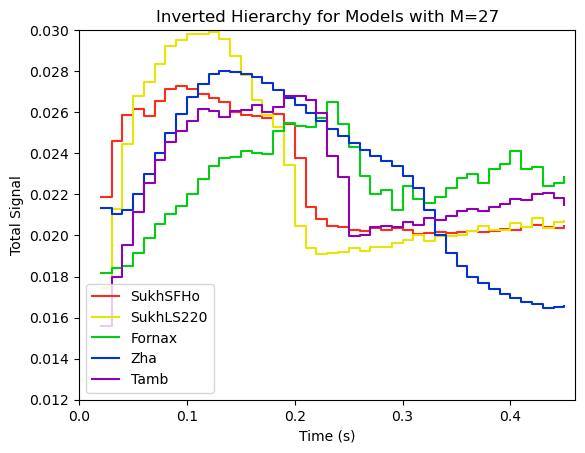

In [72]:
dt = 10 * u.ms
colors_nmo=['#fc2b1c','#e6e602','#02cf13','#0232cf','#9200b3']
colors_imo=['#fc968b','#faf1b1','#7ffc72','#91aafa','#e88bfc']
mod_names=['sukh_sfho','sukh_ls220','forn','zha','tamb']


for i,mod in enumerate(mod_names):
    m=np.max(hits_tot[mod][1])
    norm_hits=hits_tot[mod][1]/m
    
    plt.step(t[id5:id6], hits_norm[mod][1], where='post',color=colors_nmo[i],label=f'{mod_labs[i]}')

#plt.step(t[id5:id6], all_data['sukh_sfho_nmo'][0], where='post',color='orange')
plt.legend(loc='lower left')
plt.xlim(0,.46)
plt.ylim(.012,.03)
plt.xlabel('Time (s)')
plt.ylabel('Total Signal')
plt.title('Inverted Hierarchy for Models with M=27')

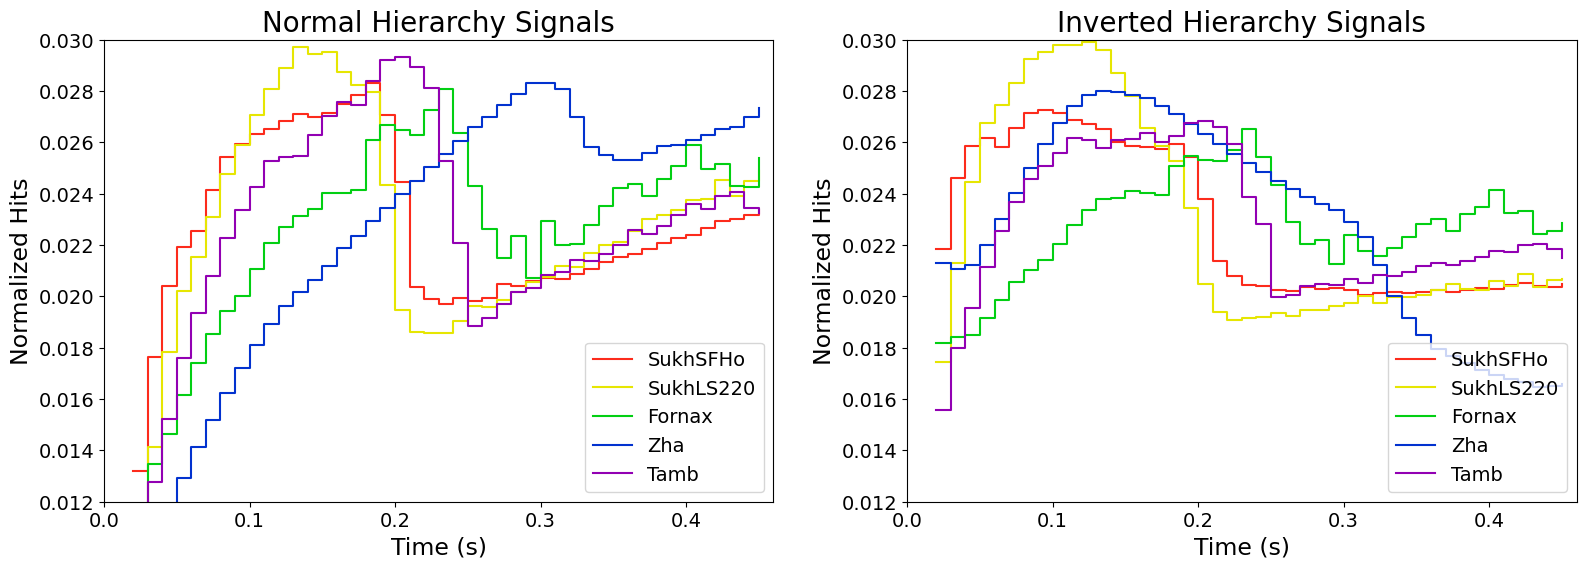

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(19, 6))
axes = axes.flatten()
for i,mod in enumerate(mod_names):
    axes[0].step(t[id5:id6], hits_norm[mod][0], where='post',color=colors_nmo[i],label=f'{mod_labs[i]}')

axes[0].legend(loc='lower right',fontsize=14)
axes[0].set_xlim(0,.46)
axes[0].set_ylim(.012,.03)
axes[0].set_xlabel('Time (s)',fontsize=17)
axes[0].set_ylabel('Normalized Hits',fontsize=17)
axes[0].set_title('Normal Hierarchy Signals',fontsize=20)
axes[0].tick_params(axis='both', which='major', labelsize=14)

for i,mod in enumerate(mod_names):
    axes[1].step(t[id5:id6], hits_norm[mod][1], where='post',color=colors_nmo[i],label=f'{mod_labs[i]}')

axes[1].legend(loc='lower right',fontsize=14)
axes[1].set_xlim(0,.46)
axes[1].set_ylim(.012,.03)
axes[1].set_xlabel('Time (s)',fontsize=17)
axes[1].set_ylabel('Normalized Hits',fontsize=17)
axes[1].set_title('Inverted Hierarchy Signals',fontsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=14)
plt.savefig('norm_sig_indep.png', dpi=300, bbox_inches='tight')

In [5]:
def compute_chi_sq_norm(pred,dat):
    chi_sq=0
    for i in range(len(pred)):
        #chi_sq += ((pred[i]-dat[i])**2)/(1/dat[i])
        chi_sq += ((pred[i]-dat[i])**2)
    return chi_sq

In [71]:
test_dat=norm_data_hits[0]
test_1=hits_norm['sukh_sfho'][0]
test_2=(np.append(hits_tot['sukh_sfho'][1][20:],
                  hits_tot['sukh_sfho'][1][24:]))/np.sum(np.append(hits_tot['sukh_sfho'][1][:20],
                                                                  hits_tot['sukh_sfho'][1][:25]))

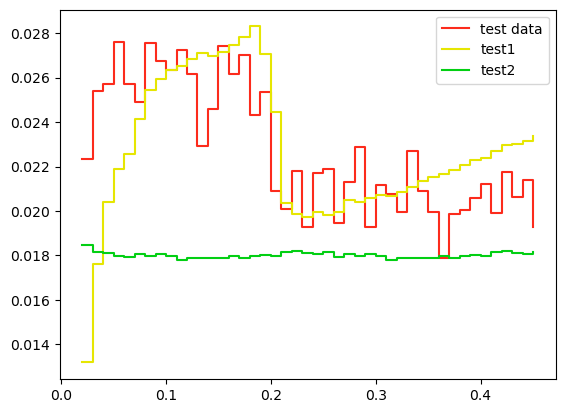

In [72]:
plt.step(t[id5:id6], test_dat, where='post',color=colors_nmo[0],label='test data')
plt.step(t[id5:id6], test_1, where='post',color=colors_nmo[1],label='test1')
plt.step(t[id5:id6], test_2, where='post',color=colors_nmo[2],label='test2')
plt.legend()

In [73]:
print(compute_chi_sq_norm(test_1,test_dat))
print(compute_chi_sq_norm(test_2,test_dat))
print(compute_chi_sq_norm(test_1,test_dat)-compute_chi_sq_norm(test_2,test_dat))

0.00036691334458311623
0.0013375604582358126
-0.0009706471136526963


In [21]:
delta_sukh_sfho = {
    'sukh_sfho_nmo': [],
    'sukh_sfho_imo': [],
    'sukh_ls220_nmo': [],
    'sukh_ls220_imo': [],
    'forn_nmo': [],
    'forn_imo': [],
    'zha_nmo': [],
    'zha_imo': [],
    'tamb_nmo': [],
    'tamb_imo': []
}


for j in range(1000):
    for i,mod in enumerate(mod_names):
        chi_nmo=compute_chi_sq_norm(hits_norm[mod][0],norm_data_hits[j])
        chi_imo=compute_chi_sq_norm(hits_norm[mod][1],norm_data_hits[j])
        delta_sukh_sfho[f'{mod}_nmo'].append(chi_nmo)
        delta_sukh_sfho[f'{mod}_imo'].append(chi_imo)

In [40]:
delta_sukh_sfho_tot = {
    'nmo': np.sum([delta_sukh_sfho['sukh_sfho_nmo'], delta_sukh_sfho['sukh_ls220_nmo'],
                   delta_sukh_sfho['forn_nmo'], delta_sukh_sfho['zha_nmo']], axis=0),
    'imo': np.sum([delta_sukh_sfho['sukh_sfho_imo'], delta_sukh_sfho['sukh_ls220_imo'],
                   delta_sukh_sfho['forn_imo'], delta_sukh_sfho['zha_imo']], axis=0)
}


Text(0.5, 1.0, 'Chi Sq for NH and IH of Sukhbold LS220 Compared to 1,000 NH Data Samples')

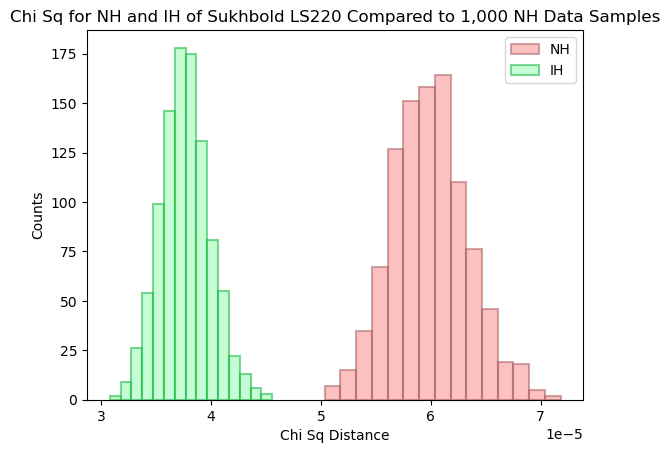

In [41]:
plt.hist(delta_sukh_sfho_tot['nmo'], alpha=0.5, color='#fa8787', edgecolor='#a35656', linewidth=1.5,label='NH',bins=15)
plt.hist(delta_sukh_sfho_tot['imo'], alpha=0.5, color='#90fcad', edgecolor='#02b031', linewidth=1.5,label='IH',bins=15)
plt.legend()
plt.xlabel('Chi Sq Distance')
plt.ylabel('Counts')
plt.title('Chi Sq for NH and IH of Sukhbold LS220 Compared to 1,000 NH Data Samples')

Text(0.5, 1.0, 'Chi Sq for NH and IH of Zha Compared to 1,000 NH Data Samples')

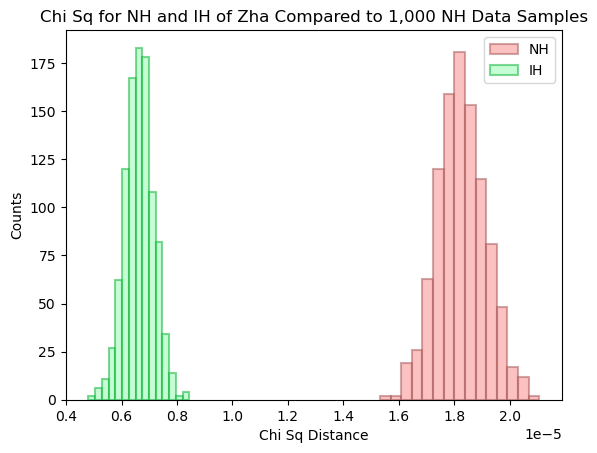

In [43]:
plt.hist(delta_sukh_sfho['zha_nmo'], alpha=0.5, color='#fa8787', edgecolor='#a35656', linewidth=1.5,label='NH',bins=15)
plt.hist(delta_sukh_sfho['zha_imo'], alpha=0.5, color='#90fcad', edgecolor='#02b031', linewidth=1.5,label='IH',bins=15)
plt.legend()
plt.xlabel('Chi Sq Distance')
plt.ylabel('Counts')
plt.title('Chi Sq for NH and IH of Zha Compared to 1,000 NH Data Samples')

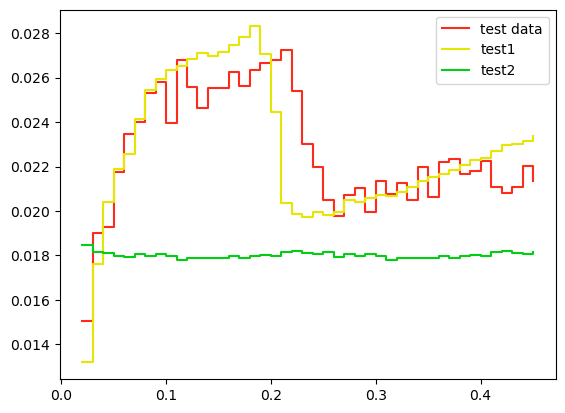

**KS TEST**

In [11]:
hits_tot = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

hits_norm = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

dt=1*u.ms
#max_t_dat = t1[np.argmax(norm_data_hits[0])]
for i,mod in enumerate(mod_names):
    for j in range(2):
        simm=sims[mod][j]
        simm.rebin_result(dt)
        simm.scale_result(10*u.kpc)
        t, hits = simm.detector_signal(dt)
        id5=np.where(t==.02*u.s)[0][0]
        id6=np.where(t==1*u.s)[0][0]
        
        data=hits[id5:id6]
        hits_tot[mod].append(data) 
        
        s=np.sum(data)
        norm_hits_sum=data/s
        
        hits_norm[mod].append(norm_hits_sum) 

In [321]:
dt=1*u.ms
data_sim=sims['sukh_sfho'][1]
data_sim.rebin_result(dt)
data_sim.scale_result(10*u.kpc)
norm_data_hits=[]
for i in range(1000):
    t, hits = data_sim.detector_signal(dt)
    bg1 = data_sim.detector.i3_bg(dt,size=hits.size) + data_sim.detector.dc_bg(dt,size=hits.size)
    sig=bg1+hits
    id1=np.where(t==-5*u.s)[0][0]
    id2=np.where(t==-.5*u.s)[0][0]
    id5=np.where(t==.02*u.s)[0][0]
    id6=np.where(t==1*u.s)[0][0]

    mean_under=np.mean(sig[id1:id2])
    data_hits=np.subtract(sig,mean_under)[id5:id6]

    s=np.sum(data_hits)
    norm_data_hits.append(data_hits/s)

Text(0.5, 1.0, 'Normalized Signal by Sum for Models with NH, M=27, d=10kpc, 10ms binning')

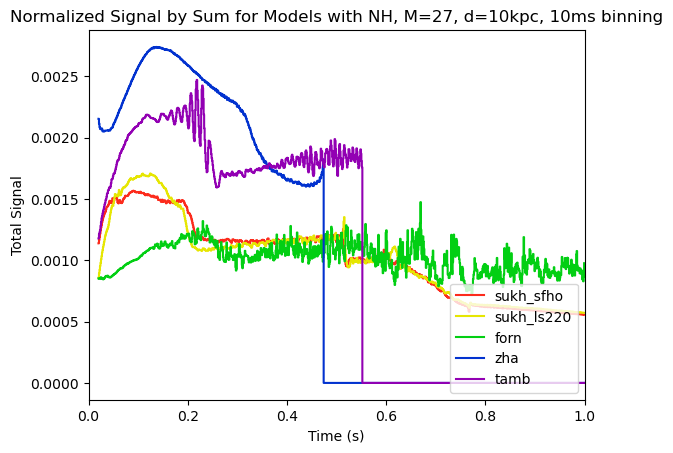

In [324]:
#dt = 10 * u.ms
colors_nmo=['#fc2b1c','#e6e602','#02cf13','#0232cf','#9200b3']
colors_imo=['#fc968b','#faf1b1','#7ffc72','#91aafa','#e88bfc']
mod_names=['sukh_sfho','sukh_ls220','forn','zha','tamb']


for i,mod in enumerate(mod_names):
    m=np.max(hits_tot[mod][0])
    norm_hits=hits_tot[mod][0]/m
    
    s=np.sum(hits_tot[mod][0])
    norm_hits_sum=hits_tot[mod][0]/s
    
    plt.step(t[id5:id6], hits_norm[mod][1], where='post',color=colors_nmo[i],label=f'{mod}')

#plt.step(t[id5:id6], norm_data_hits[0], where='post',color='orange')
    
plt.legend(loc='lower right')
plt.xlim(0,1)
plt.xlabel('Time (s)')
plt.ylabel('Total Signal')
plt.title('Normalized Signal by Sum for Models with NH, M=27, d=10kpc, 10ms binning')

In [274]:
ks_sukh_sfho_nmo = {
    'sukh_sfho_nmo': [],
    'sukh_sfho_imo': [],
    'sukh_ls220_nmo': [],
    'sukh_ls220_imo': [],
    'forn_nmo': [],
    'forn_imo': [],
    'zha_nmo': [],
    'zha_imo': [],
    'tamb_nmo': [],
    'tamb_imo': []
}

for j in range(1000):
    for i,mod in enumerate(mod_names):
        sorted_nmo=np.sort(hits_norm[mod][0])
        sorted_imo=np.sort(hits_norm[mod][1])
        sorted_dat=np.sort(norm_data_hits[j])
        stat_nmo, p_value = stats.ks_2samp(sorted_dat, sorted_nmo, alternative='two-sided', mode='auto')
        stat_imo, p_value = stats.ks_2samp(sorted_dat, sorted_imo, alternative='two-sided', mode='auto')
        ks_sukh_sfho_nmo[f'{mod}_nmo'].append(stat_nmo)
        ks_sukh_sfho_nmo[f'{mod}_imo'].append(stat_imo)     

Text(0.5, 1.0, 'KS for NH and IH of Sukhbold SFHo Compared to 1,000 NH Data Samples')

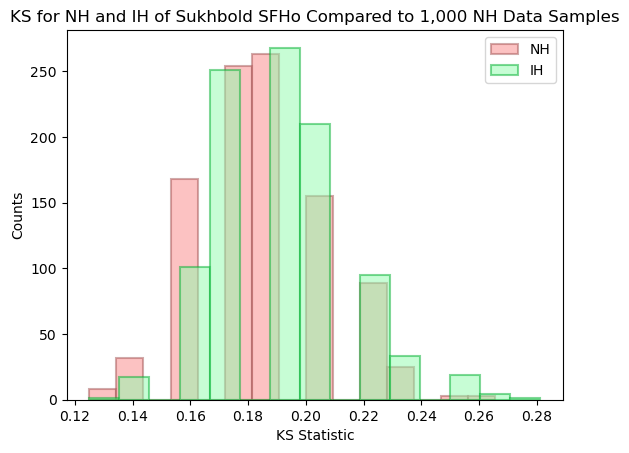

In [275]:
plt.hist(ks_sukh_sfho_nmo['sukh_sfho_nmo'], alpha=0.5, color='#fa8787', edgecolor='#a35656', linewidth=1.5,label='NH',bins=15)
plt.hist(ks_sukh_sfho_nmo['sukh_sfho_imo'], alpha=0.5, color='#90fcad', edgecolor='#02b031', linewidth=1.5,label='IH',bins=15)
plt.legend()
plt.xlabel('KS Statistic')
plt.ylabel('Counts')
plt.title('KS for NH and IH of Sukhbold SFHo Compared to 1,000 NH Data Samples')

In [118]:
def compute_ks_pval(area_tot,ks_dist,statistic):
    if(statistic>=np.median(ks_dist)):
        dist_above=ks_dist[ks_dist>=statistic]
        if len(dist_above)==0:
            return 1/area_tot
        else:
            return len(dist_above)/area_tot
    else:
        dist_below=ks_dist[ks_dist<=statistic]
        if len(dist_below)==0:
            return -1/area_tot
        else:
            return -len(dist_below)/area_tot

In [120]:
p_sukh_sfho_nmo = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}



for i,mod in enumerate(mod_names):
    for j,stat in enumerate(ks_sukh_sfho_nmo[f'{mod}_nmo']):
        p=compute_ks_pval(1000,np.array(ks_sukh_sfho_nmo[f'{mod}_imo']),stat)
        p_sukh_sfho_nmo[mod].append(p)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   4., 995.]),
 array([-0.041     , -0.03833333, -0.03566667, -0.033     , -0.03033333,
        -0.02766667, -0.025     , -0.02233333, -0.01966667, -0.017     ,
        -0.01433333, -0.01166667, -0.009     , -0.00633333, -0.00366667,
        -0.001     ]),
 <BarContainer object of 15 artists>)

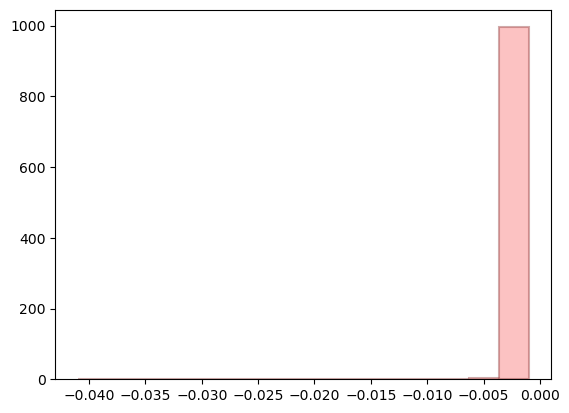

In [182]:
plt.hist(p_sukh_sfho_nmo['sukh_sfho'], alpha=0.5, color='#fa8787', edgecolor='#a35656', linewidth=1.5,label='NH',bins=15)

In [191]:
p_fin_sukh_sfho_nmo = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

for i,mod in enumerate(mod_names):
    med=np.median(p_sukh_sfho_nmo[mod])
    q1 = np.percentile(p_sukh_sfho_nmo[mod], 2.5)
    q3 = np.percentile(p_sukh_sfho_nmo[mod], 97.5)
    iqr = q3 - q1
    std=np.std(p_sukh_sfho_nmo[mod])
    p_fin_sukh_sfho_nmo[mod].append(med)
    p_fin_sukh_sfho_nmo[mod].append(iqr)

In [6]:
def get_final_pvals(norm_data_hits1,hits_norm1):
    ks_test = {
    'sukh_sfho_nmo': [],
    'sukh_sfho_imo': [],
    'sukh_ls220_nmo': [],
    'sukh_ls220_imo': [],
    'forn_nmo': [],
    'forn_imo': [],
    'zha_nmo': [],
    'zha_imo': [],
    'tamb_nmo': [],
    'tamb_imo': []
    }
    
    p_vals = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
    }
    
    p_fin = {
        'sukh_sfho': [],
        'sukh_ls220': [],
        'forn': [],
        'zha': [],
        'tamb': []
    }

    for j in range(1000):
        for i,mod in enumerate(mod_names):
            sorted_nmo=np.sort(hits_norm1[mod][0])
            sorted_imo=np.sort(hits_norm1[mod][1])
            sorted_dat=np.sort(norm_data_hits1[j])
            stat_nmo, p_value = stats.ks_2samp(sorted_dat, sorted_nmo, alternative='two-sided', mode='auto')
            stat_imo, p_value = stats.ks_2samp(sorted_dat, sorted_imo, alternative='two-sided', mode='auto')
            ks_test[f'{mod}_nmo'].append(stat_nmo)
            ks_test[f'{mod}_imo'].append(stat_imo)  
    
    for i,mod in enumerate(mod_names):
        for j,stat in enumerate(ks_test[f'{mod}_nmo']):
            p=compute_ks_pval(1000,np.array(ks_test[f'{mod}_imo']),stat)
            p_vals[mod].append(p)
    
    for i,mod in enumerate(mod_names):
        med=np.median(p_vals[mod])
        q1 = np.percentile(p_vals[mod], 5)
        q3 = np.percentile(p_vals[mod], 95)
        iqr = q3 - q1
        std=np.std(p_sukh_sfho_nmo[mod])
        p_fin[mod].append(med)
        p_fin[mod].append(iqr)
    return p_fin

In [7]:
def quad_fit(x, a, b):
    return a*x + b

In [8]:
def compute_chi_sq_norm(pred,dat):
    chi_sq=0
    for i in range(len(pred)):
        chi_sq += ((pred[i]-dat[i])**2)/(1/dat[i])
        chi_sq += ((pred[i]-dat[i])**2)
    return chi_sq

In [9]:
def compute_p_val(area_tot,start,params,stat,chis_nh,bin_width):
    a,b=params
    upper=-1/a*(5000+b)
    lower=stat
    if(lower<start):
        area=len(chis_nh[np.logical_and(chis_nh>stat,chis_nh<start)])*bin_width+1/a*(np.exp(a*upper+b)-np.exp(a*start+b))
    else:
        area=1/a*(np.exp(a*upper+b)-np.exp(a*lower+b))
    area_full=.9*area_tot*bin_width + 1/a*(np.exp(a*upper+b)-np.exp(a*start+b))
    return area/area_full

In [10]:
def compute_chi_sq(pred,dat):
    chi_sq=0
    for i in range(len(pred)):
        chi_sq += ((pred[i]-dat[i])**2)/(dat[i])
    return chi_sq

In [11]:
def dist_to_pval_with_plot(data,nh,ih,nbins):
    chis_nh=[]
    chis_ih=[]
    for i, dat in enumerate(data):
        chis_nh.append(compute_chi_sq_norm(nh,dat))
        chis_ih.append(compute_chi_sq_norm(ih,dat))
        
    chis_nh=np.array(chis_nh)
    chis_ih=np.array(chis_ih)
    
    if(np.median(chis_nh)>=np.median(chis_ih)):
        hist_nh, bin_edges_nh = np.histogram(chis_nh, bins=nbins)
        hist_ih, bin_edges_ih = np.histogram(chis_ih, bins=nbins)
        bin_width_nh = bin_edges_nh[1] - bin_edges_nh[0]

        cumulative_nh = np.cumsum(hist_nh)
        split_nh = np.searchsorted(cumulative_nh, .9*len(data))

        tail_region_nh = slice(-(len(hist_nh)-split_nh), None)

        params_nh, cov_nh = curve_fit(quad_fit, bin_edges_nh[tail_region_nh], np.log(hist_nh[tail_region_nh]+1))
        a_nh, b_nh = params_nh

        p_vals=[]
        for i,chi_ih in enumerate(chis_ih):
            p=compute_p_val(len(data),bin_edges_nh[split_nh],params_nh,chi_ih,chis_nh,bin_width_nh)
            p_vals.append(p)

        x_nh=np.linspace(bin_edges_nh[split_nh],
                         bin_edges_nh[split_nh]+2000,500)
        y_fit_nh = np.exp(a_nh*x_nh+b_nh)

        return norm.isf(np.median(p_vals)),chis_nh,chis_ih,y_fit_nh,x_nh
        #return norm.isf(np.median(p_vals))
    else:
        hist_nh, bin_edges_nh = np.histogram(chis_nh, bins=nbins)
        hist_ih, bin_edges_ih = np.histogram(chis_ih, bins=nbins)
        bin_width_ih = bin_edges_ih[1] - bin_edges_ih[0]

        cumulative_ih = np.cumsum(hist_ih)
        split_ih = np.searchsorted(cumulative_ih, .9*len(data))

        tail_region_ih = slice(-(len(hist_ih)-split_ih), None)

        params_ih, cov_ih = curve_fit(quad_fit, bin_edges_ih[tail_region_ih], np.log(hist_ih[tail_region_ih]+1))
        a_ih, b_ih = params_ih

        p_vals=[]
        for i,chi_nh in enumerate(chis_nh):
            p=compute_p_val(len(data),bin_edges_ih[split_ih],params_ih,chi_nh,chis_ih,bin_width_ih)
            p_vals.append(p)

        x_ih=np.linspace(bin_edges_ih[split_ih],
                         bin_edges_ih[split_ih]+2000,500)
        y_fit_ih = np.exp(a_ih*x_ih+b_ih)

        return -1*norm.isf(np.median(p_vals)),chis_nh,chis_ih,y_fit_ih,x_ih
        #return -1*norm.isf(np.median(p_vals))

In [17]:
all_dists = {
    'sukh_sfho_nmo': [],
    'sukh_sfho_imo': [],
    'sukh_ls220_nmo': [],
    'sukh_ls220_imo': [],
    'forn_nmo': [],
    'forn_imo': [],
    'zha_nmo': [],
    'zha_imo': [],
    'tamb_nmo': [],
    'tamb_imo': []
    }
names=list(all_dists.keys())
all_mod_names=['sukh_sfho','sukh_sfho','sukh_ls220','sukh_ls220','forn','forn','zha','zha','tamb','tamb']

for i,name in enumerate(names):
    typ=i%2
    dist_fin = {
        'sukh_sfho': [],
        'sukh_ls220': [],
        'forn': [],
        'zha': [],
        'tamb': []
    }
    for j,mod in enumerate(mod_names):
        
        nmo_dist=compute_chi_sq_norm(hits_norm[mod][0],hits_norm[all_mod_names[i]][typ])
        imo_dist=compute_chi_sq_norm(hits_norm[mod][1],hits_norm[all_mod_names[i]][typ])
        if(typ==0):
            dist=imo_dist-nmo_dist
        else:
            dist=nmo_dist-imo_dist
        dist_fin[mod].append(dist)
        
    all_dists[name]=dist_fin

In [18]:
all_data = {
    'sukh_sfho_nmo': [],
    'sukh_sfho_imo': [],
    'sukh_ls220_nmo': [],
    'sukh_ls220_imo': [],
    'forn_nmo': [],
    'forn_imo': [],
    'zha_nmo': [],
    'zha_imo': [],
    'tamb_nmo': [],
    'tamb_imo': []
    }

names=list(all_data.keys())
for k,name in enumerate(names):
    typ=k%2
    dist_fin = {
        'sukh_sfho': [],
        'sukh_ls220': [],
        'forn': [],
        'zha': [],
        'tamb': []
    }

    data=[]
    dt=10*u.ms
    for i in range(1000):
        sims[all_mod_names[k]][typ].rebin_result(dt)
        sims[all_mod_names[k]][typ].scale_result(10*u.kpc)
        t, hits = sims[all_mod_names[k]][typ].detector_signal(dt)
        bg1 = sims[all_mod_names[k]][typ].detector.i3_bg(dt,size=hits.size) + sims[all_mod_names[k]][typ].detector.dc_bg(dt,size=hits.size)
        sig=bg1+hits
        id1=np.where(t==-5*u.s)[0][0]
        id2=np.where(t==-.5*u.s)[0][0]
        id5=np.where(t==.02*u.s)[0][0]
        id6=np.where(t==.46*u.s)[0][0]

        mean_under=np.mean(sig[id1:id2])
        data_hits=np.subtract(sig,mean_under)[id5:id6]

        s=np.sum(data_hits)
        data.append(data_hits/s)
    all_data[name]=data


In [79]:
compute_chi_sq_norm(hits_norm['sukh_sfho'][0],all_data['sukh_sfho_nmo'][0])

0.0003298222994024313

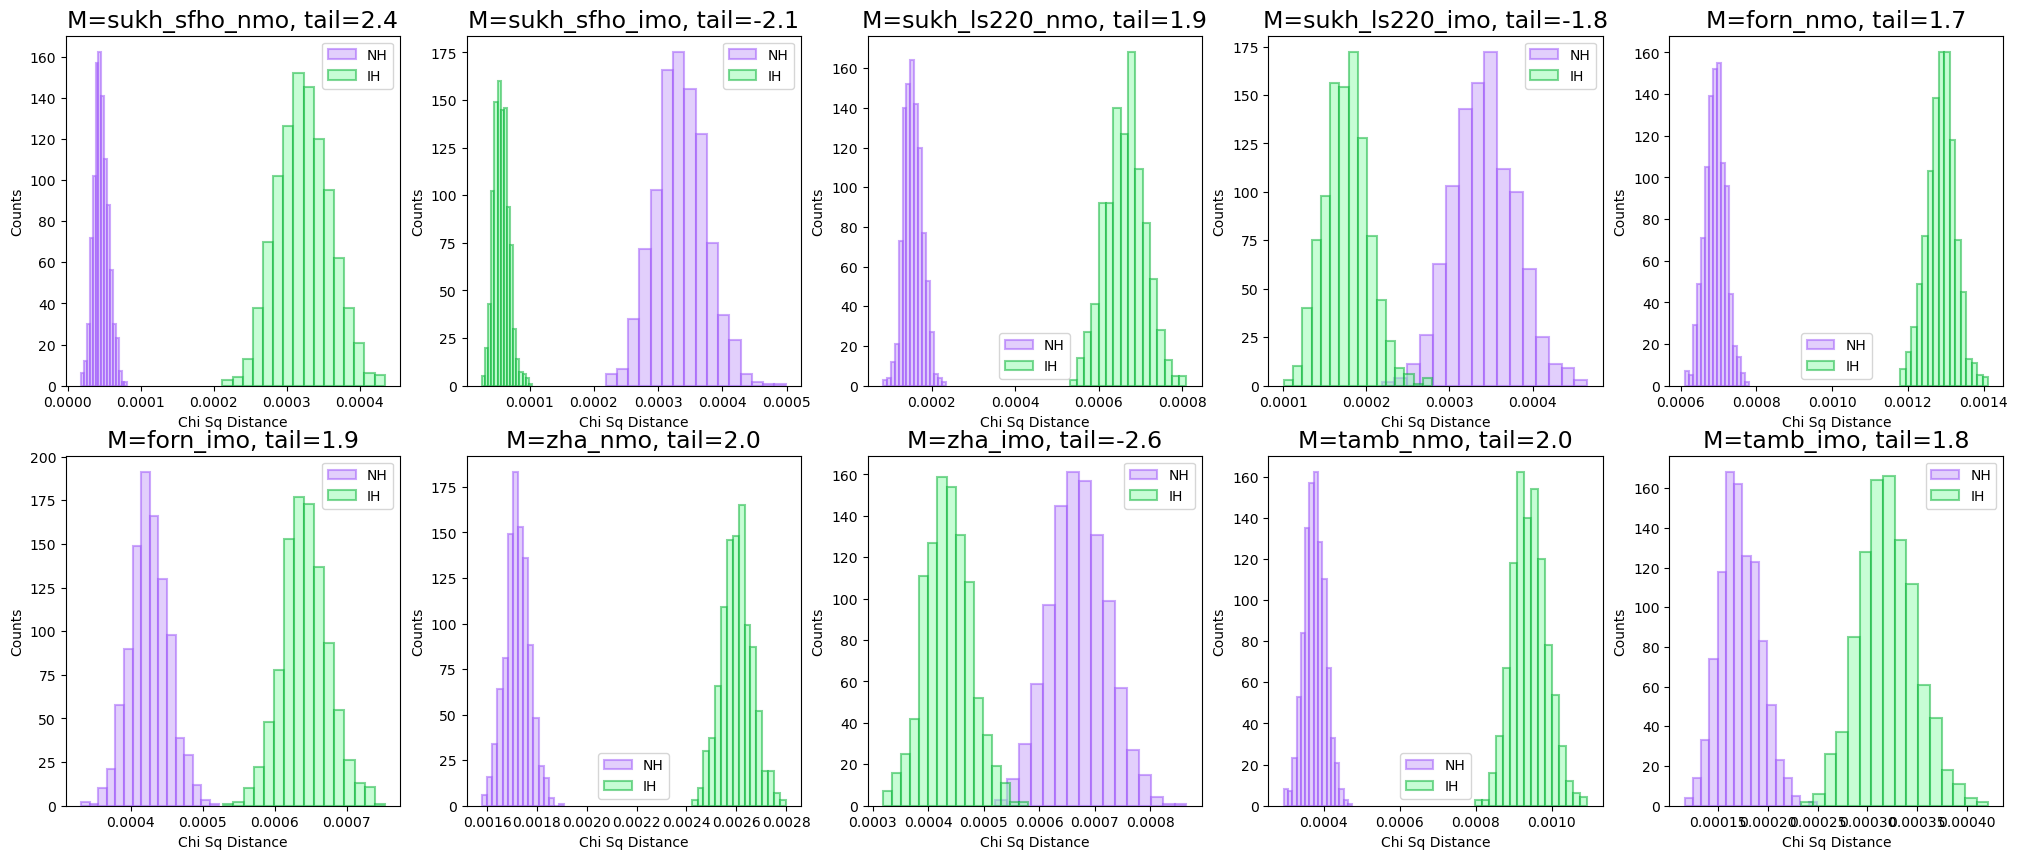

In [38]:
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.flatten()

for i,ax in enumerate(axes):

    p_vals,chi_nh,chi_ih,y_fit_nh,x_nh = dist_to_pval_with_plot(np.array(all_data[names[i]]),
                                                                np.array(hits_norm['sukh_sfho'][0]),
                                                                np.array(hits_norm['sukh_sfho'][1]),24)
    ax.hist(chi_nh, alpha=0.5, color='#c7a0fa', edgecolor='#9b52fa', 
                linewidth=1.5,label='NH',bins=16)
    ax.hist(chi_ih, alpha=0.5, color='#90fcad', edgecolor='#02b031', 
                linewidth=1.5,label='IH',bins=16)
    #ax.plot(x_nh, y_fit_nh, color='#6534cf', label='NH fit')
        
        
    ax.legend()
    ax.set_xlabel('Chi Sq Distance')
    ax.set_ylabel('Counts')
    ax.set_title('M={}, tail={}'.format(names[i],round(p_vals,1)),fontsize=17)

In [28]:
all_dists = {
    'sukh_sfho_nmo': [],
    'sukh_sfho_imo': [],
    'sukh_ls220_nmo': [],
    'sukh_ls220_imo': [],
    'forn_nmo': [],
    'forn_imo': [],
    'zha_nmo': [],
    'zha_imo': [],
    'tamb_nmo': [],
    'tamb_imo': []
    }
names=list(all_dists.keys())
all_mod_names=['sukh_sfho','sukh_sfho','sukh_ls220','sukh_ls220','forn','forn','zha','zha','tamb','tamb']

for k,name in enumerate(names):
    typ=k%2
    dist_fin = {
        'sukh_sfho': [],
        'sukh_ls220': [],
        'forn': [],
        'zha': [],
        'tamb': []
    }

    data=[]
    for i in range(1000):
        t, hits = sims[all_mod_names[k]][typ].detector_signal(dt)
        bg1 = sims[all_mod_names[k]][typ].detector.i3_bg(dt,size=hits.size) + sims[all_mod_names[k]][typ].detector.dc_bg(dt,size=hits.size)
        sig=bg1+hits
        id1=np.where(t==-5*u.s)[0][0]
        id2=np.where(t==-.5*u.s)[0][0]
        id5=np.where(t==.02*u.s)[0][0]
        id6=np.where(t==.46*u.s)[0][0]

        mean_under=np.mean(sig[id1:id2])
        data_hits=np.subtract(sig,mean_under)[id5:id6]

        s=np.sum(data_hits)
        data.append(data_hits/s)
        
    for j,mod in enumerate(mod_names):        
        dist=dist_to_pval_with_plot(data,hits_norm[mod][0],hits_norm[mod][1],24)[0]
        if(typ==1):
            dist=-1*dist
        dist_fin[mod].append(dist)
        
    all_dists[name]=dist_fin

In [72]:
compute_chi_sq_norm(hits_norm['forn'][1],
                    hits_norm['sukh_sfho'][0])-compute_chi_sq_norm(hits_norm['forn'][0],
                                                                 hits_norm['sukh_sfho'][0])

-6.028824578611221e-06

In [92]:
all_dists['sukh_sfho_nmo']

{'sukh_sfho': [1.8588899464071056],
 'sukh_ls220': [1.7338491682165498],
 'forn': [-1.6886729134133103],
 'zha': [-2.0378855702821346],
 'tamb': [-2.891250391293126]}

In [70]:
all_dists['sukh_ls220_imo']

{'sukh_sfho': [6.348195567770234e-06],
 'sukh_ls220': [1.1407137148979993e-05],
 'forn': [1.457732103946725e-05],
 'zha': [5.915075645883275e-05],
 'tamb': [2.5659678384991083e-06]}

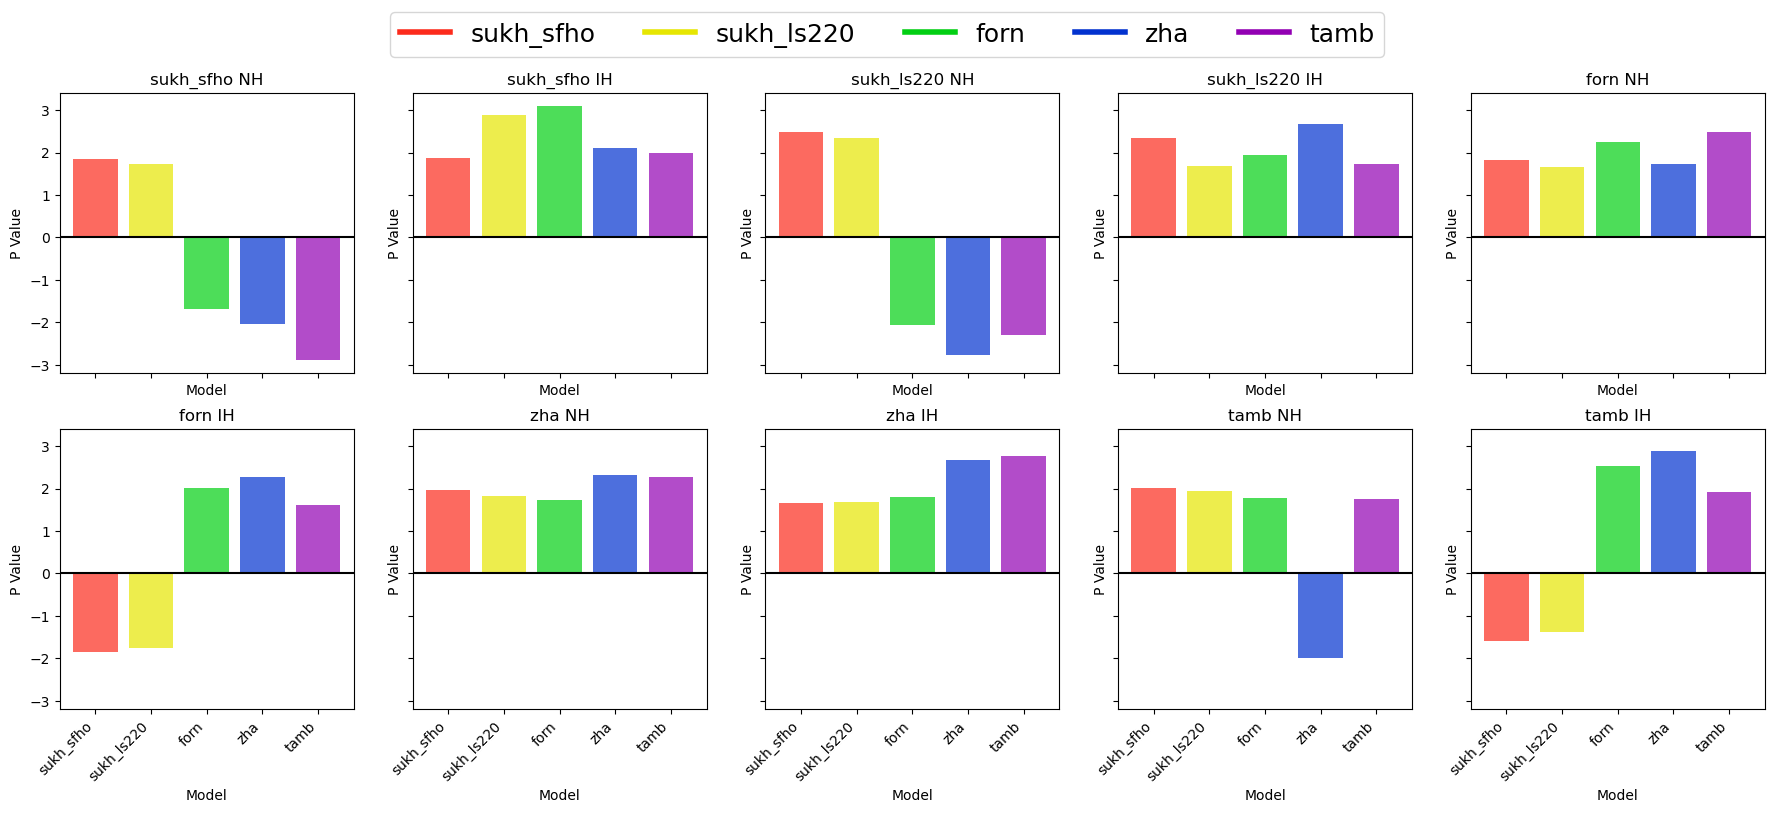

In [93]:
colors_nmo=['#fc2b1c','#e6e602','#02cf13','#0232cf','#9200b3']
x_pos = np.arange(len(mod_names))
labs=['NH','IH']

fig, axes = plt.subplots(2, 5, figsize=(22, 8),sharex=True,sharey=True)
axes = axes.flatten()
for i,ax in enumerate(axes):
    sett=all_dists[names[i]]
    p_vals = np.array([array[0] for array in sett.values()])
    #bars = ax.bar(x_pos, p_vals,yerr=p_errs,capsize=5, alpha=0.7, color=colors_nmo, error_kw={'elinewidth':1, 'ecolor':'black'})
    bars = ax.bar(x_pos, p_vals,capsize=5, alpha=0.7, color=colors_nmo, error_kw={'elinewidth':1, 'ecolor':'black'})

    # Add labels to each bar
    """
    for j,bar in enumerate(bars):
        yval = bar.get_height()
        if (p_errs[j]==0):
            if yval > 0:
                ax.text(bar.get_x() + bar.get_width()/2.0, -.0015, f'{yval}', ha='center', va='center')
            else:
                ax.text(bar.get_x() + bar.get_width()/2.0, .0015, f'{yval}', ha='center', va='center')
        else:
            if yval > 0:
                ax.text(bar.get_x() + bar.get_width()/2.0, -.0015, f'{yval} \u00B1 {round(p_errs[j],3)}', ha='center', va='center')
            else:
                ax.text(bar.get_x() + bar.get_width()/2.0, .0015, f'{yval} \u00B1 {round(p_errs[j],3)}', ha='center', va='center')

    """
    ax.axhline(y=0, color='black')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(mod_names)

    ax.set_xlabel('Model')
    ax.set_ylabel('P Value')
    #ax.set_ylim(-.01,.01)

    ax.set_title(f'{all_mod_names[i]} {labs[i%2]}')
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')


legend_handles = [plt.Line2D([0], [0], color=color, lw=4, label=name) for name, color in zip(mod_names, colors_nmo)]
fig.legend(handles=legend_handles, labels=mod_names, loc='upper center', ncol=len(mod_names),fontsize=18)

#fig.suptitle('KS Test P Values of Models for Different Datasets with M=27, d=10kpc, 5ms binning, cutoff after .46s',fontsize=20)


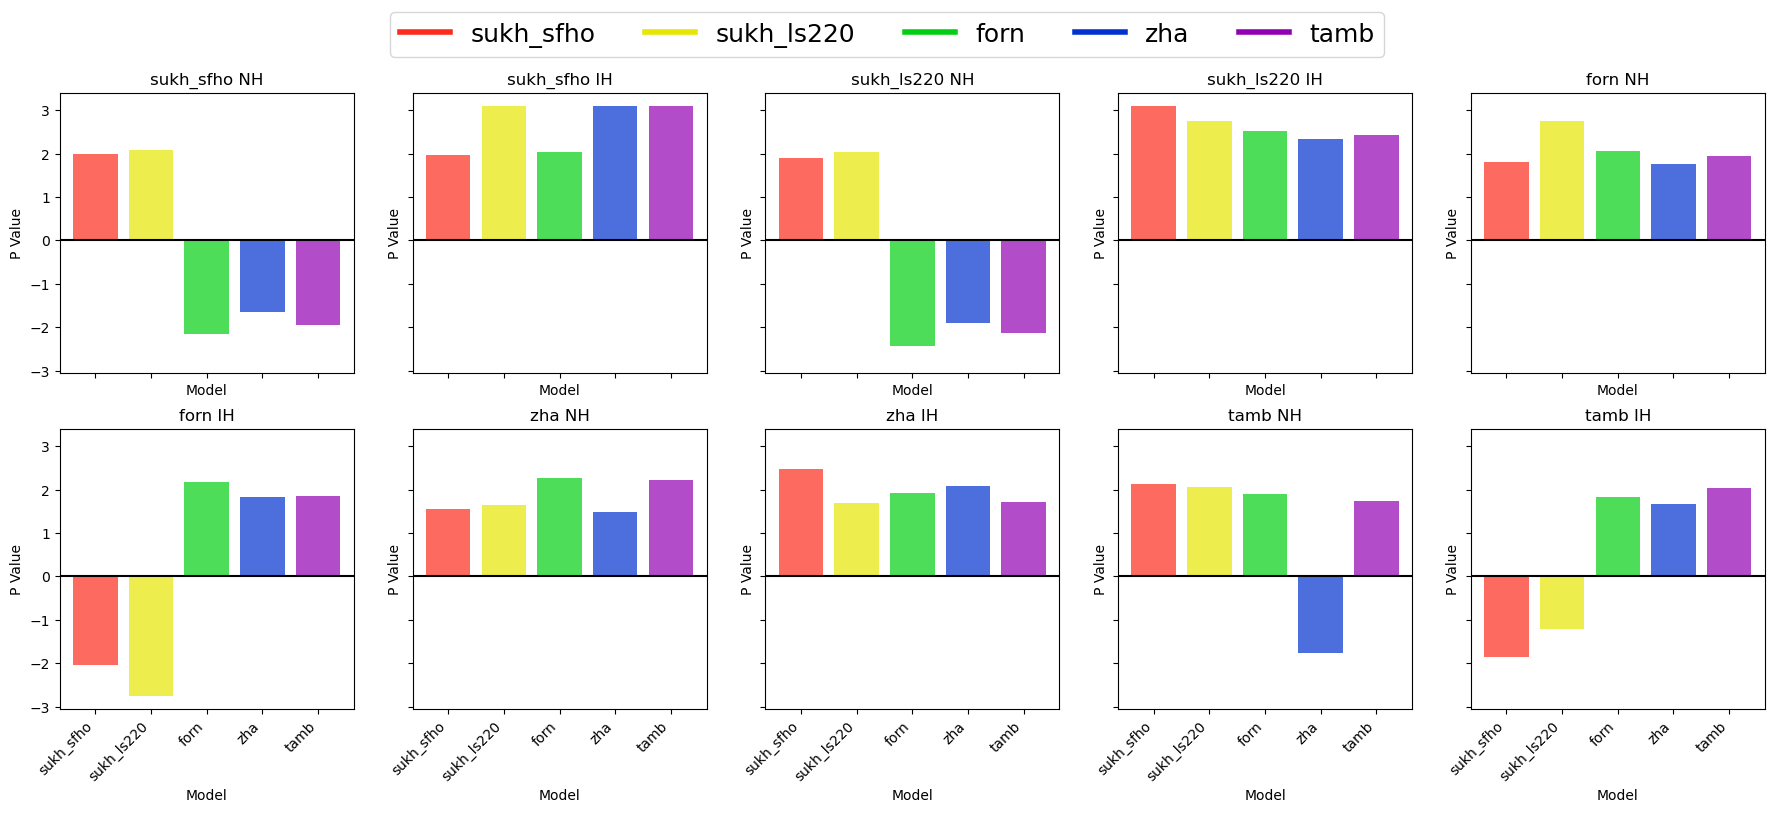

In [40]:
colors_nmo=['#fc2b1c','#e6e602','#02cf13','#0232cf','#9200b3']
x_pos = np.arange(len(mod_names))
labs=['NH','IH']

fig, axes = plt.subplots(2, 5, figsize=(22, 8),sharex=True,sharey=True)
axes = axes.flatten()
for i,ax in enumerate(axes):
    sett=all_dists[names[i]]
    p_vals = np.array([array[0] for array in sett.values()])
    #bars = ax.bar(x_pos, p_vals,yerr=p_errs,capsize=5, alpha=0.7, color=colors_nmo, error_kw={'elinewidth':1, 'ecolor':'black'})
    bars = ax.bar(x_pos, p_vals,capsize=5, alpha=0.7, color=colors_nmo, error_kw={'elinewidth':1, 'ecolor':'black'})

    # Add labels to each bar
    """
    for j,bar in enumerate(bars):
        yval = bar.get_height()
        if (p_errs[j]==0):
            if yval > 0:
                ax.text(bar.get_x() + bar.get_width()/2.0, -.0015, f'{yval}', ha='center', va='center')
            else:
                ax.text(bar.get_x() + bar.get_width()/2.0, .0015, f'{yval}', ha='center', va='center')
        else:
            if yval > 0:
                ax.text(bar.get_x() + bar.get_width()/2.0, -.0015, f'{yval} \u00B1 {round(p_errs[j],3)}', ha='center', va='center')
            else:
                ax.text(bar.get_x() + bar.get_width()/2.0, .0015, f'{yval} \u00B1 {round(p_errs[j],3)}', ha='center', va='center')

    """
    ax.axhline(y=0, color='black')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(mod_names)

    ax.set_xlabel('Model')
    ax.set_ylabel('P Value')
    #ax.set_ylim(-.01,.01)

    ax.set_title(f'{all_mod_names[i]} {labs[i%2]}')
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')


legend_handles = [plt.Line2D([0], [0], color=color, lw=4, label=name) for name, color in zip(mod_names, colors_nmo)]
fig.legend(handles=legend_handles, labels=mod_names, loc='upper center', ncol=len(mod_names),fontsize=18)

#fig.suptitle('KS Test P Values of Models for Different Datasets with M=27, d=10kpc, 5ms binning, cutoff after .46s',fontsize=20)


In [29]:
dist_fin = {
        'sukh_sfho': [],
        'sukh_ls220': [],
        'forn': [],
        'zha': [],
        'tamb': []
}
for i,name in enumerate(mod_names):
    for j,name2 in enumerate(mod_names):
        mins=min(all_dists[f'{name}_nmo'][name2],all_dists[f'{name}_imo'][name2])
        dist_fin[name].append(mins)

In [24]:
df

NameError: name 'df' is not defined

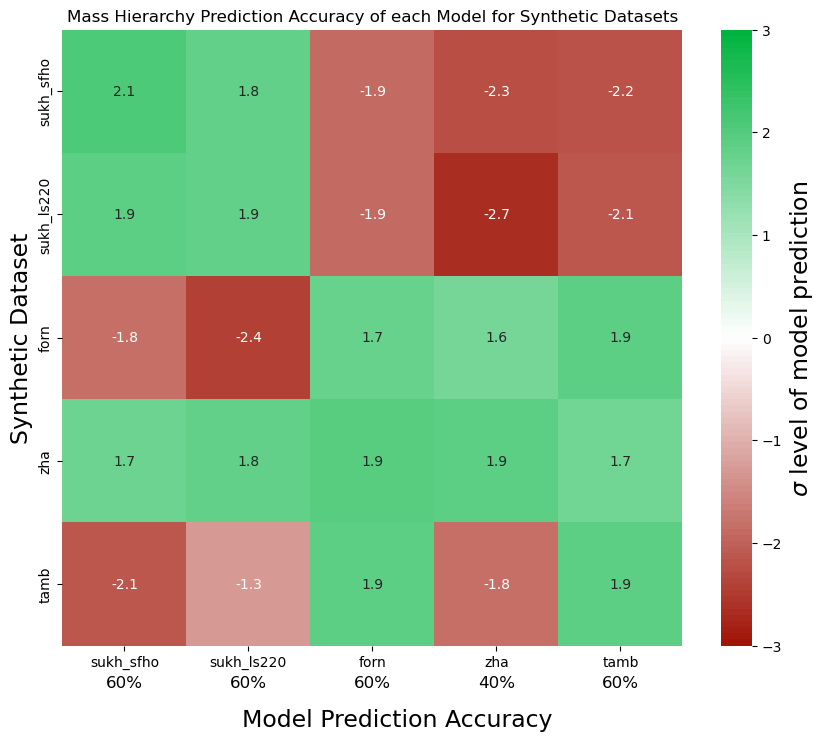

In [30]:
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap



colors = ["#a11508", "white", "#00b33e"]
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'custom_diverging'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)


model_names = list(dist_fin.keys())
all_predictions = [np.array(dist_fin[model_name]).flatten() for model_name in model_names]

# Create confusion matrix
confusion_matrix = np.array(all_predictions)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(confusion_matrix, annot=True, cmap=cm, 
                      cbar_kws={'label': '$\sigma$ level of model prediction'},
                      vmin=-3, vmax=3, xticklabels=model_names, yticklabels=model_names)

colorbar = heatmap.collections[0].colorbar
colorbar.set_label('$\sigma$ level of model prediction', fontsize=17)

plt.ylabel('Synthetic Dataset', fontsize=17)
plt.title('Mass Hierarchy Prediction Accuracy of each Model for Synthetic Datasets')

positive_counts = np.sum(confusion_matrix > 0, axis=0)
total_counts = confusion_matrix.shape[0]
accuracies = (positive_counts / total_counts) * 100

for i, model_name in enumerate(model_names):
    plt.text(i + 0.5, 5.3, f'{accuracies[i]:.0f}%', ha='center', va='center', fontsize=12)
    
plt.text(2.7,5.6,'Model Prediction Accuracy', ha='center', va='center', fontsize=17)

plt.show()

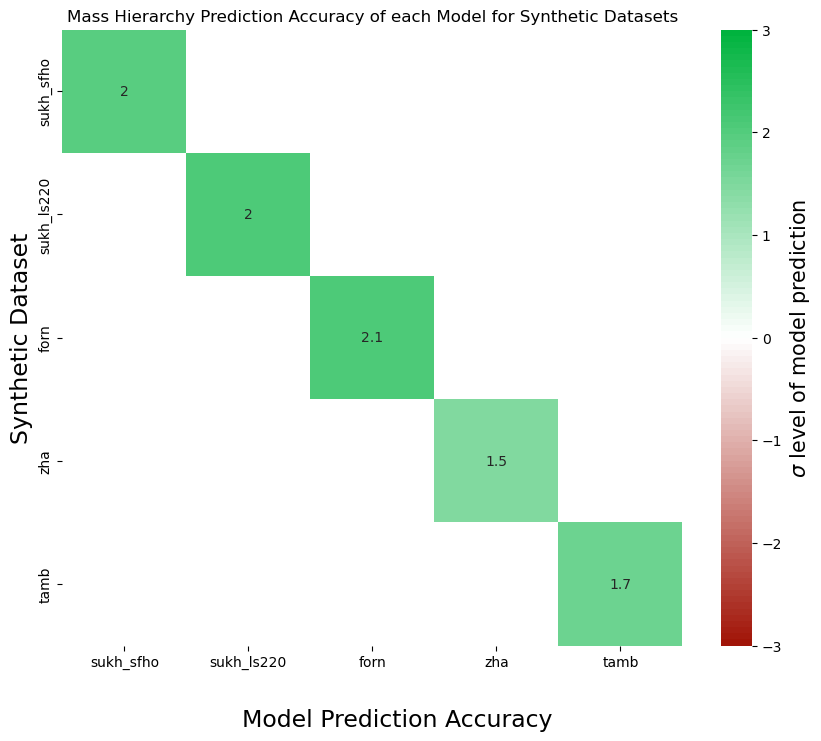

In [45]:

colors = ["#a11508", "white", "#00b33e"]
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'custom_diverging'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

model_names = list(dist_fin.keys())
all_predictions = [np.array(dist_fin[model_name]).flatten() for model_name in model_names]

# Create confusion matrix
confusion_matrix = np.array(all_predictions)

# Create a mask for the off-diagonal elements
mask = np.ones_like(confusion_matrix, dtype=bool)
np.fill_diagonal(mask, False)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(confusion_matrix, annot=True, cmap=cm, 
                      cbar_kws={'label': '$\sigma$ level of model prediction'},
                      vmin=-3, vmax=3, xticklabels=model_names, yticklabels=model_names, mask=mask)

# Access the colorbar and set its label fontsize
colorbar = heatmap.collections[0].colorbar
colorbar.set_label('$\sigma$ level of model prediction', fontsize=15)  # Set your desired fontsize here

plt.ylabel('Synthetic Dataset', fontsize=17)
plt.title('Mass Hierarchy Prediction Accuracy of each Model for Synthetic Datasets')

positive_counts = np.sum(confusion_matrix > 0, axis=0)
total_counts = confusion_matrix.shape[0]
accuracies = (positive_counts / total_counts) * 100

plt.text(2.7, 5.6, 'Model Prediction Accuracy', ha='center', va='center', fontsize=17)

plt.show()

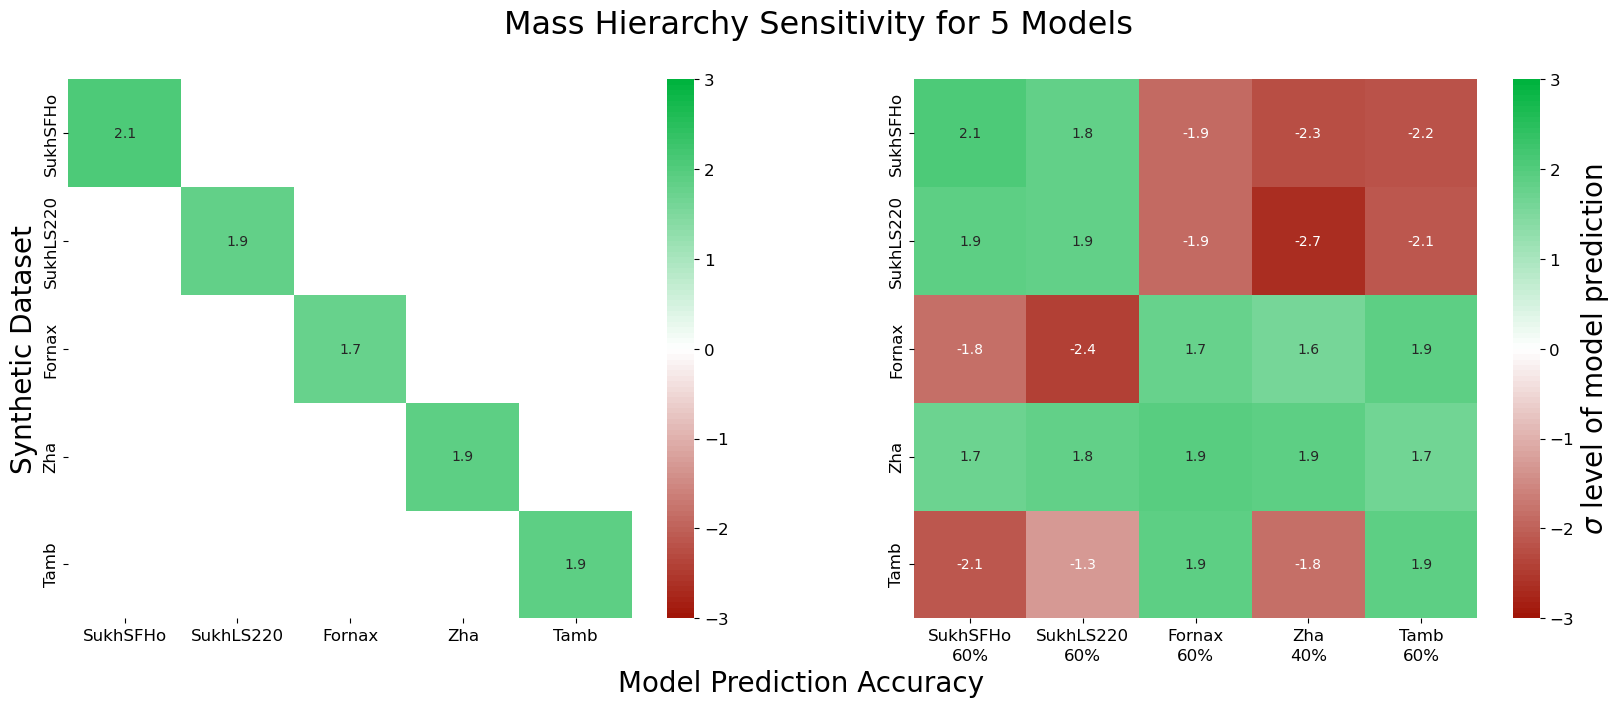

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
axes = axes.flatten()

model_names_fin=['SukhSFHo','SukhLS220','Fornax','Zha','Tamb']

colors = ["#a11508", "white", "#00b33e"]
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'custom_diverging'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

model_names = list(dist_fin.keys())
all_predictions = [np.array(dist_fin[model_name]).flatten() for model_name in model_names]

# Create confusion matrix
confusion_matrix = np.array(all_predictions)

# Create a mask for the off-diagonal elements
mask = np.ones_like(confusion_matrix, dtype=bool)
np.fill_diagonal(mask, False)

heatmap = sns.heatmap(confusion_matrix, annot=True, cmap=cm, ax=axes[0],
                      vmin=-3, vmax=3, xticklabels=model_names_fin, yticklabels=model_names_fin, mask=mask)

axes[0].set_ylabel('Synthetic Dataset', fontsize=20)
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=12)

#fig.suptitle('Mass Hierarchy Sensitivity for 5 Models',fontsize=20)

axes[0].text(6.5, 5.6, 'Model Prediction Accuracy', ha='center', va='center', fontsize=20)
axes[0].set_xticklabels(axes[0].get_xticklabels(), fontsize=12)
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=12)






colors = ["#a11508", "white", "#00b33e"]
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'custom_diverging'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)


model_names = list(dist_fin.keys())
all_predictions = [np.array(dist_fin[model_name]).flatten() for model_name in model_names]

# Create confusion matrix
confusion_matrix = np.array(all_predictions)
heatmap = sns.heatmap(confusion_matrix, annot=True, cmap=cm, ax=axes[1],
                      cbar_kws={'label': '$\sigma$ level of model prediction'},
                      vmin=-3, vmax=3, xticklabels=model_names_fin, yticklabels=model_names_fin)

colorbar = heatmap.collections[0].colorbar
colorbar.set_label('$\sigma$ level of model prediction', fontsize=20)


positive_counts = np.sum(confusion_matrix > 0, axis=0)
total_counts = confusion_matrix.shape[0]
accuracies = (positive_counts / total_counts) * 100

axes[1].set_xticklabels(axes[1].get_xticklabels(), fontsize=12)
axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize=12)

colorbar.ax.tick_params(labelsize=12)

for i, model_name in enumerate(model_names):
    axes[1].text(i + 0.5, 5.35, f'{accuracies[i]:.0f}%', ha='center', va='center', fontsize=12)
    
fig.suptitle('Mass Hierarchy Sensitivity for 5 Models', fontsize=23)
plt.savefig('sig_mod_ind1.png', dpi=300, bbox_inches='tight')

In [ ]:
all_pvals = {
    'sukh_sfho_nmo': [],
    'sukh_sfho_imo': [],
    'sukh_ls220_nmo': [],
    'sukh_ls220_imo': [],
    'forn_nmo': [],
    'forn_imo': [],
    'zha_nmo': [],
    'zha_imo': [],
    'tamb_nmo': [],
    'tamb_imo': []
    }
names=list(all_pvals.keys())
all_mod_names=['sukh_sfho','sukh_sfho','sukh_ls220','sukh_ls220','forn','forn','zha','zha','tamb','tamb']

for i,name in enumerate(names):
    typ=i%2
    dt=5*u.ms
    data_sim=sims[all_mod_names[i]][typ]
    data_sim.rebin_result(dt)
    data_sim.scale_result(10*u.kpc)
    norm_data_hits=[]
    for i in range(1000):
        t, hits = data_sim.detector_signal(dt)
        bg1 = data_sim.detector.i3_bg(dt,size=hits.size) + data_sim.detector.dc_bg(dt,size=hits.size)
        sig=bg1+hits
        id1=np.where(t==-5*u.s)[0][0]
        id2=np.where(t==-.5*u.s)[0][0]
        id5=np.where(t==.02*u.s)[0][0]
        id6=np.where(t==.36*u.s)[0][0]

        mean_under=np.mean(sig[id1:id2])
        data_hits=np.subtract(sig,mean_under)[id5:id6]

        s=np.sum(data_hits)
        norm_data_hits.append(data_hits/s)
    
    all_pvals[name]=get_final_pvals(norm_data_hits,hits_norm)

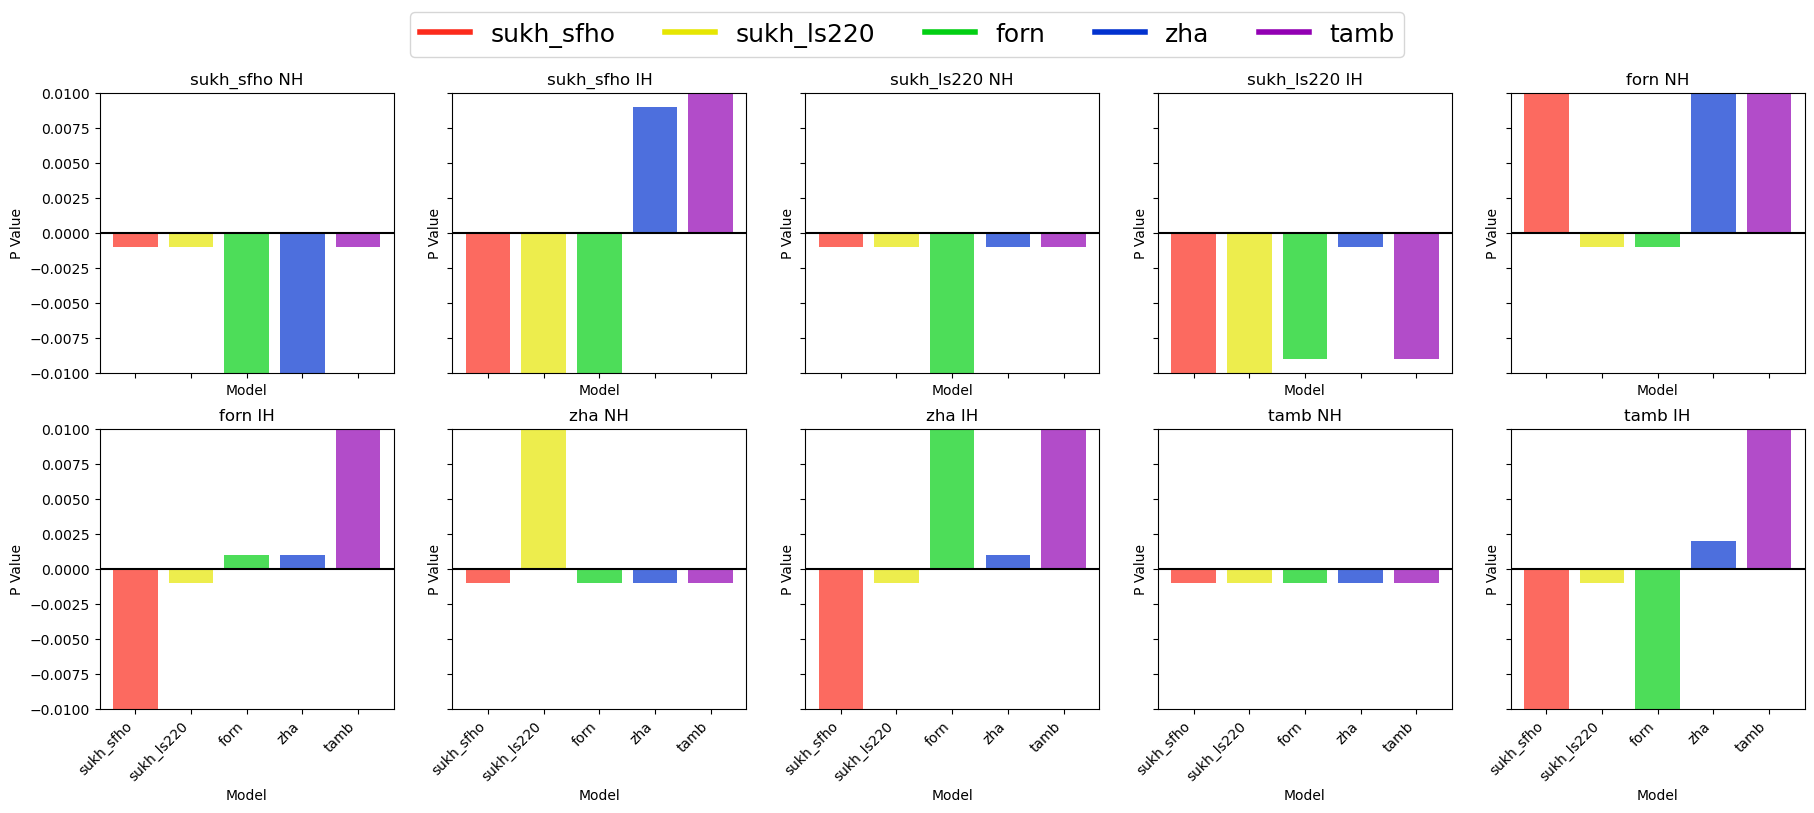

In [312]:
colors_nmo=['#fc2b1c','#e6e602','#02cf13','#0232cf','#9200b3']
x_pos = np.arange(len(mod_names))
labs=['NH','IH']

fig, axes = plt.subplots(2, 5, figsize=(22, 8),sharex=True,sharey=True)
axes = axes.flatten()
for i,ax in enumerate(axes):
    sett=all_pvals[names[i]]
    p_vals = np.array([array[0] for array in sett.values()])
    p_errs = np.array([array[1] for array in sett.values()])
    #bars = ax.bar(x_pos, p_vals,yerr=p_errs,capsize=5, alpha=0.7, color=colors_nmo, error_kw={'elinewidth':1, 'ecolor':'black'})
    bars = ax.bar(x_pos, p_vals,capsize=5, alpha=0.7, color=colors_nmo, error_kw={'elinewidth':1, 'ecolor':'black'})

    # Add labels to each bar
    """
    for j,bar in enumerate(bars):
        yval = bar.get_height()
        if (p_errs[j]==0):
            if yval > 0:
                ax.text(bar.get_x() + bar.get_width()/2.0, -.0015, f'{yval}', ha='center', va='center')
            else:
                ax.text(bar.get_x() + bar.get_width()/2.0, .0015, f'{yval}', ha='center', va='center')
        else:
            if yval > 0:
                ax.text(bar.get_x() + bar.get_width()/2.0, -.0015, f'{yval} \u00B1 {round(p_errs[j],3)}', ha='center', va='center')
            else:
                ax.text(bar.get_x() + bar.get_width()/2.0, .0015, f'{yval} \u00B1 {round(p_errs[j],3)}', ha='center', va='center')

    """
    ax.axhline(y=0, color='black')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(mod_names)

    ax.set_xlabel('Model')
    ax.set_ylabel('P Value')
    ax.set_ylim(-.01,.01)

    ax.set_title(f'{all_mod_names[i]} {labs[i%2]}')
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')


legend_handles = [plt.Line2D([0], [0], color=color, lw=4, label=name) for name, color in zip(mod_names, colors_nmo)]
fig.legend(handles=legend_handles, labels=mod_names, loc='upper center', ncol=len(mod_names),fontsize=18)

#fig.suptitle('KS Test P Values of Models for Different Datasets with M=27, d=10kpc, 5ms binning, cutoff after .46s',fontsize=20)
